In [ ]:
# hide
# skip
! [ -e /content ] && pip install -Uqq model_inspector nbdev
# For colab. Restart the runtime after running this cell!

In [ ]:
# default_exp inspect

# inspect

> Inspect models.

In [ ]:
# hide
from nbdev.showdoc import *  # noqa: F401

In [ ]:
# export
# Meant to be colorblind-friendly
COLORS = {"blue": "#377eb8", "orange": "#ff7f00", "green": "#4daf4a", "pink": "#f781bf"}

In [ ]:
# export
import warnings
from enum import Enum, auto
from typing import Callable, Iterable, List, Optional, Sequence, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import waterfall_chart
from fastcore.basics import GetAttr, basic_repr, store_attr
from fastcore.test import test_fig_exists
from IPython.display import HTML
from matplotlib.axes import Axes
from model_inspector.delegate import delegates
from model_inspector.explore import plot_column_clusters, show_correlation
from model_inspector.tune import (
    calculate_metrics_by_thresh_binary,
    calculate_metrics_by_thresh_multi,
    confusion_matrix,
)
from sklearn.base import ClassifierMixin, RegressorMixin, clone
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model._base import LinearClassifierMixin, LinearModel
from sklearn.model_selection._search import BaseSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import BaseDecisionTree, plot_tree
from sklearn.utils import check_X_y
from sklearn.utils.validation import check_is_fitted

In [ ]:
# export
class _Inspector(GetAttr):
    """Model inspector base class

    Users should use `get_inspector` to generate appropriate
    `_Inspector` objects rather than instantiating this class or its
    subclasses directly.

    Subclasses of this class are based on distinctions among model types
    only, including the distinction between binary and multiclass
    classification. Plotting functionality that depends on how many
    columns are in the feature DataFrame is delegated to a separate
    `_Plotter` class hierarchy. We use custom `__getattr__` and
    `__dir__` methods to expose the `_Plotter` methods through the
    `_Inspector` object, so that the user does not need to interact with
    the `_Plotter` directly.
    """

    def __init__(self, model, X, y):
        check_is_fitted(model)
        check_X_y(X, y)
        if not isinstance(model, (DummyClassifier, DummyRegressor)):
            model._check_n_features(X, reset=False)

        store_attr()
        self._plotter = self._get_plotter_class()(self.model, self.X, self.y)
        self.default = self._plotter

    __repr__ = basic_repr(["model"])

    def _get_plotter_class(self):
        result = _Plotter
        num_features = len(self.X.columns)
        model_type = identify_type(self.model, self.y)
        if model_type is ModelType.REGRESSION:
            if num_features == 1:
                result = _Reg1dPlotter
            elif num_features == 2:
                if hasattr(self.model, "estimators_"):
                    result = _Reg2dMultiPlotter
                else:
                    result = _Reg2dPlotter
        elif model_type is ModelType.BINARY:
            if num_features == 1:
                result = _Bin1dPlotter
            elif num_features == 2:
                if hasattr(self.model, "estimators_"):
                    result = _Bin2dMultiPlotter
                else:
                    result = _Bin2dPlotter
        else:
            if num_features == 1:
                result = _Multi1dPlotter
            elif num_features == 2:
                if hasattr(self.model, "estimators_"):
                    result = _Multi2dMultiPlotter
                else:
                    result = _Multi2dPlotter
        return result

    @delegates(sklearn.inspection.permutation_importance)
    def permutation_importance(
        self,
        sort: bool = True,
        **kwargs,
    ) -> pd.Series:
        """Calculate permutation importance

        - `sort`: Sort features by decreasing importance
        """
        if kwargs is None:
            kwargs = {}
        kwargs = {**{"n_jobs": -1}, **kwargs}

        importances = pd.Series(
            permutation_importance(self.model, self.X, self.y, **kwargs)[
                "importances_mean"
            ],
            index=self.X.columns,
        )
        if sort:
            importances = importances.sort_values(ascending=False)
        return importances

    def plot_permutation_importance(
        self,
        ax: Optional[Axes] = None,
        importance_kwargs: Optional[dict] = None,
        plot_kwargs: Optional[dict] = None,
    ) -> Axes:
        """Plot a correlation matrix for `self.X` and `self.y`

        Parameters:
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        - `importance_kwargs`: kwargs to pass to
        `sklearn.inspection.permutation_importance`
        - `plot_kwargs`: kwargs to pass to `pd.Series.plot.barh`
        """
        if importance_kwargs is None:
            importance_kwargs = {}
        # reversing the order to compensate for `barh` reversing it
        importance = self.permutation_importance(**importance_kwargs).iloc[::-1]

        if plot_kwargs is None:
            plot_kwargs = {}
        ax = importance.plot.barh(**plot_kwargs)
        ax.set(title="Feature importances")
        ax.bar_label(ax.containers[0], fmt="%.2f")
        # extending plot on the right to accommodate labels
        ax.set_xlim((ax.get_xlim()[0], ax.get_xlim()[1] * 1.05))
        return ax

    @delegates(show_correlation)
    def show_correlation(self, **kwargs) -> Axes:
        """Show a correlation matrix for `self.X` and `self.y`

        If output is not rendering properly when you reopen a notebook,
        make sure the notebook is trusted.
        """
        return show_correlation(
            df=pd.concat((self.X, self.y), axis="columns"),
            **kwargs,
        )

    @delegates(plot_column_clusters)
    def plot_feature_clusters(self, **kwargs) -> Axes:
        """Plot a dendrogram based on feature correlations

        - `corr_method`: Method of correlation to pass to `df.corr()`
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        """
        return plot_column_clusters(self.X, **kwargs)

In [ ]:
# export
def get_inspector(model, X, y) -> _Inspector:
    """Get an appropriate inspector for your model and data

    Parameters:
    - `model`: Fitted sklearn model
    - `X`: Feature matrix with same shape and column meanings as
    features `model` was trained on
    - `y`: Target series with same length as `X` and same meaning as
    target `model` was trained on
    """
    model_type = identify_type(model, y)
    if isinstance(model, LinearModel):
        return _LinRegInspector(model, X, y)
    elif isinstance(model, LinearClassifierMixin):
        return (
            _LinBinInspector(model, X, y)
            if model_type == ModelType.BINARY
            else _LinMultiInspector(model, X, y)
        )
    elif isinstance(model, BaseDecisionTree):
        return (
            _TreeRegInspector(model, X, y)
            if model_type == ModelType.REGRESSION
            else _TreeBinInspector(model, X, y)
            if model_type == ModelType.BINARY
            else _TreeMultiInspector(model, X, y)
        )
    elif isinstance(model, BaseSearchCV):
        return _SearchInspector(model, X, y)
    elif model_type == ModelType.BINARY:
        return _BinClasInspector(model, X, y)
    elif model_type == ModelType.MULTICLASS:
        return _MultiClasInspector(model, X, y)
    elif model_type == ModelType.REGRESSION:
        return _RegInspector(model, X, y)
    else:
        raise NotImplementedError("Model not supported")

In [ ]:
# hide
# export
def identify_type(model, y):
    if isinstance(model, RegressorMixin):
        return ModelType.REGRESSION
    elif isinstance(model, ClassifierMixin):
        return ModelType.BINARY if len(y.unique()) == 2 else ModelType.MULTICLASS
    elif isinstance(model, BaseSearchCV):
        return identify_type(model.best_estimator_, y)
    else:
        return ModelType.OTHER

In [ ]:
# hide
# export
class ModelType(Enum):
    REGRESSION = auto()
    BINARY = auto()
    MULTICLASS = auto()
    OTHER = auto()

In [ ]:
# export
class _BinClasInspector(_Inspector):
    def calculate_metrics_by_thresh(
        self,
        metrics: Union[Callable, Sequence[Callable]],
        thresholds: Optional[Sequence] = None,
    ) -> pd.DataFrame:
        """Calculate classification metrics as a function of threshold

        Assumes that `self.model` has a `.predict_proba()` method. Uses
        `self.y` as ground-truth values,
        `self.model.predict_proba(self.X)[:, 1] > thresh` as
        predictions.

        Parameters:
        - `metrics`: Callables that take `y_true`, `y_pred` as
        positional arguments and return a number. Must have a `__name__`
        attribute.
        - `thresholds`: `Sequence` of `float` threshold values to use. By
        default uses `0` and the values that appear in `y_prob[:, 1]`, which
        is a minimal set that covers all of the relevant possibilities. One
        reason to override that default would be to save time with a large
        dataset.

        Returns: DataFrame with one column "thresh" indicating the
        thresholds used and an additional column for each input metric
        giving the value of that metric at that threshold.
        """
        return calculate_metrics_by_thresh_binary(
            y_true=self.y,
            y_prob=self.model.predict_proba(self.X),
            metrics=metrics,
            thresholds=thresholds,
        )

    @delegates(sklearn.metrics.confusion_matrix)
    def confusion_matrix(
        self,
        thresh: float = 0.5,
        **kwargs,
    ) -> pd.DataFrame:
        """Get confusion matrix

        Assumes that `self.model` has a `.predict_proba()` method. Uses
        `self.y` as ground-truth values,
        `self.model.predict_proba(self.X)[:, 1] > thresh` as
        predictions.

        If output is not rendering properly when you reopen a notebook,
        make sure the notebook is trusted.

        Parameters:
        - `thresh`: Probability threshold for counting a prediction as
        positive
        """
        labels = np.unique(self.y)
        return confusion_matrix(
            y_true=self.y,
            y_pred=np.where(
                self.model.predict_proba(self.X)[:, 1] > thresh, labels[1], labels[0]
            ),
            **kwargs,
        )

In [ ]:
# export
class _MultiClasInspector(_Inspector):
    def calculate_metrics_by_thresh(
        self,
        metrics: Union[Callable, Sequence[Callable]],
        thresholds: Optional[Sequence] = None,
    ) -> pd.DataFrame:
        """Calculate classification metrics as a function of threshold

        Assumes that `self.model` has a `.predict_proba()` method. Uses
        `self.y` as ground-truth values, uses the value with the highest
        probability as the prediction if that probability exceeds the
        threshold, `np.nan` otherwise.

        Parameters:
        - `metrics`: Callables that take `y_true`, `y_pred` as
        positional arguments and return a number. Must have a `__name__`
        attribute and must be able to handle `np.nan` values.
        - `thresholds`: `Sequence` of `float` threshold values to use. By
        default uses 0 and all values that appear in `y_prob`, which is a
        minimal set that covers all of the relevant possibilities. One
        reason to override that default would be to save time with a large
        dataset.

        Returns: DataFrame with one column "thresh" indicating the
        thresholds used and an additional column for each input metric
        giving the value of that metric at that threshold.
        """
        return calculate_metrics_by_thresh_multi(
            y_true=self.y,
            y_prob=self.model.predict_proba(self.X),
            metrics=metrics,
        )

    @delegates(pd.DataFrame().style.background_gradient)
    def confusion_matrix(
        self,
        **kwargs,
    ) -> pd.DataFrame:
        """Get confusion matrix

        Uses `self.y` as ground-truth values,
        `self.model.predict(self.X)` as predictions.

        If output is not rendering properly when you reopen a notebook,
        make sure the notebook is trusted.
        """

        return confusion_matrix(
            y_true=self.y,
            y_pred=self.model.predict(self.X),
            **kwargs,
        )

In [ ]:
# export
class _RegInspector(_Inspector):
    def plot_pred_vs_act(
        self,
        ax: Optional[Axes] = None,
        scatter_kwargs: Optional[dict] = None,
        line_kwargs: Optional[dict] = None,
    ) -> Axes:
        """Plot predicted vs. actual values

        Parameters:
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        - `scatter_kwargs`: kwargs to pass to `plt.scatter`
        - `line_kwargs`: kwargs to pass to `plt.plot`
        """
        if ax is None:
            _, ax = plt.subplots()

        if scatter_kwargs is None:
            scatter_kwargs = {}
        scatter_kwargs = {**{"alpha": 0.3}, **scatter_kwargs}
        if "c" not in scatter_kwargs and "color" not in scatter_kwargs:
            scatter_kwargs["c"] = "k"
        y_pred = self.model.predict(self.X)
        ax.scatter(self.y, y_pred, **scatter_kwargs)

        if line_kwargs is None:
            line_kwargs = {}
        line_kwargs = {
            **{"label": "predicted=actual", "linestyle": "dashed"},
            **line_kwargs,
        }
        ax.plot(
            [self.y.min(), self.y.max()],
            [self.y.min(), self.y.max()],
            **line_kwargs,
        )

        ax.set(xlabel="Actual", ylabel="Predicted")
        ax.legend()
        return ax

    def plot_residuals(
        self,
        axes: Optional[np.array] = None,
        scatter_kwargs: Optional[dict] = None,
        line_kwargs: Optional[dict] = None,
        hist_kwargs: Optional[dict] = None,
    ) -> Axes:
        """Plot residuals

        Parameters:
        - `axes`: 1D array of two Matplotlib `Axes` objects. Plot will
        be added to these objects if provided; otherwise a new array of
        `Axes` objects will be generated.
        - `scatter_kwargs`: kwargs to pass to `plt.scatter`
        - `line_kwargs`: kwargs to pass to `plt.plot` for line at y=0
        - `hist_kwargs`: kwargs to pass to `plt.hist` for histogram of
        residuals
        """
        if axes is None:
            _, axes = plt.subplots(
                1, 2, gridspec_kw={"width_ratios": [4, 1]}, sharey=True
            )

        if scatter_kwargs is None:
            scatter_kwargs = {}
        scatter_kwargs = {**{"alpha": 0.3}, **scatter_kwargs}
        if "c" not in scatter_kwargs and "color" not in scatter_kwargs:
            scatter_kwargs["c"] = "k"
        axes[0].scatter(
            x=self.y.index, y=self.y - self.model.predict(self.X), **scatter_kwargs
        )

        if line_kwargs is None:
            line_kwargs = {}
        line_kwargs = {**{"linestyle": "dashed"}, **line_kwargs}
        axes[0].plot([self.y.index.min(), self.y.index.max()], [0, 0], **line_kwargs)
        axes[0].set(
            ylabel="actual - predicted", xlabel=self.y.index.name, title="Residuals"
        )

        if hist_kwargs is None:
            hist_kwargs = {}
        hist_kwargs = {**{"orientation": "horizontal", "color": "k"}, **hist_kwargs}
        axes[1].hist(self.y - self.model.predict(self.X), **hist_kwargs)
        return axes

In [ ]:
# hide
# export
def generate_model_html(
    intercept: float,
    coefs: Sequence[float],
    feature_names: Iterable[str],
    target_name: str,
    intercept_formatter: str = ".2f",
    coef_formatter: str = ".2f",
):
    if len(coefs) != len(feature_names):
        raise ValueError("len(coefs) != len(feature_cols)")
    model_string = f"""
        <span style='color:{COLORS["pink"]}'>{target_name}</span>
        = <span style='color:{COLORS["orange"]}'>{intercept:{intercept_formatter}}</span>
    """  # noqa: E501
    for coef, feature_col in zip(coefs, feature_names):
        model_string += f"""
            <span style='color:{COLORS["green"]}'>{"+" if coef >= 0 else "-"} {abs(coef):{coef_formatter}}</span>
            * <span style='color:{COLORS["blue"]}'>{feature_col}</span>
        """  # noqa: E501
    return model_string

In [ ]:
# export
def _plot_waterfall(
    X,
    y,
    item: Union[pd.Series, np.array],
    intercept: float,
    coefs: Sequence[float],
    y_lab="",
    bar_num_formatter: str = ".1f",
    tick_num_formatter: str = ".2f",
    sorted_value=True,
    threshold=0.01,
    blue_color=COLORS["blue"],
    green_color=COLORS["green"],
    red_color=COLORS["orange"],
    **waterfall_kwargs,
):
    index = ["int"] + [
        f"{name}: {val:{tick_num_formatter}}" for name, val in zip(X.columns, item)
    ]
    vals = [intercept] + list(np.array(coefs) * item)
    waterfall_chart.plot(
        index=index,
        data=vals,
        x_lab="Feature name and value",
        y_lab=y_lab,
        formatting=f"{{:,{bar_num_formatter}}}",
        net_label=y.name,
        sorted_value=sorted_value,
        threshold=threshold,
        blue_color=blue_color,
        green_color=green_color,
        red_color=red_color,
        **waterfall_kwargs,
    )
    return plt.gca()

In [ ]:
# export
class _LinRegInspector(_RegInspector):
    """Linear regression model inspector"""

    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]):
        """Plot coefficient values against a hyperparameter

        Parameters:
        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        model.fit(self.X, self.y)
        column_order = model.coef_.argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coefs = []
        for val in vals:
            setattr(model, hparam, val)
            coefs.append(model.fit(X, self.y).coef_)

        fig, ax = plt.subplots()
        ax.plot(vals, coefs)
        ax.plot([vals.min(), vals.max()], [0, 0], linestyle="dotted", c="k")
        ax.axvline(current_val, c="k", label="current value")
        ax.set(xlabel=hparam, ylabel="coefficient value")
        ax.legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return ax

    @delegates(waterfall_chart.plot)
    def plot_waterfall(
        self,
        item: Union[pd.Series, np.array],
        bar_num_formatter: str = ".1f",
        tick_num_formatter: str = ".2f",
        sorted_value=True,
        threshold=0.01,
        blue_color=COLORS["blue"],
        green_color=COLORS["green"],
        red_color=COLORS["orange"],
        **kwargs,
    ):
        """Make a waterfall chart showing how each feature contributes
        to the prediction for the input item.

        Parameters:
        - `item`: Input item, with the same shape and value meanings as
        a single row from `self.X`
        - `bar_num_formatter`: Bar label format specifier
        - `tick_num_formatter`: Tick label format specifier

        Additional keyword arguments will be passed to
        `waterfall_chart.plot`
        """
        return _plot_waterfall(
            X=self.X,
            y=self.y,
            item=item,
            intercept=self.model.intercept_,
            coefs=self.model.coef_,
            y_lab="Contribution to prediction",
            bar_num_formatter=bar_num_formatter,
            tick_num_formatter=tick_num_formatter,
            sorted_value=sorted_value,
            threshold=threshold,
            blue_color=blue_color,
            green_color=green_color,
            red_color=red_color,
            **kwargs,
        )

    def show_model(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show model equation

        Parameters:
        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        return HTML(
            generate_model_html(
                intercept=self.model.intercept_,
                coefs=self.model.coef_,
                feature_names=self.X.columns,
                target_name=self.y.name,
                intercept_formatter=intercept_formatter,
                coef_formatter=coef_formatter,
            )
        )

In [ ]:
# export
class _LinBinInspector(_BinClasInspector):
    """Linear binary classification model inspector"""

    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]) -> np.array:
        """Plot coefficient values against a hyperparameter

        Parameters:
        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        column_order = model.fit(self.X, self.y).coef_[0].argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coef_arrays = []
        for val in vals:
            setattr(model, hparam, val)
            coef_arrays.append(model.fit(X, self.y).coef_)

        fig, ax = plt.subplots()
        ax.plot(vals, [coefs[0] for coefs in coef_arrays])
        ax.plot([vals.min(), vals.max()], [0, 0], linestyle="dotted", c="k")
        ax.set(xlabel=hparam, ylabel="Coefficient Value")
        ax.axvline(current_val, c="k", label="current value")
        ax.legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return ax

    def show_model(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show model equation

        Parameters:
        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        return HTML(
            generate_model_html(
                intercept=self.model.intercept_[0],
                coefs=self.model.coef_[0],
                feature_names=self.X.columns,
                target_name=f"log-odds({self.y.name})",
                intercept_formatter=intercept_formatter,
                coef_formatter=coef_formatter,
            )
        )

    @delegates(waterfall_chart.plot)
    def plot_waterfall(
        self,
        item: Union[pd.Series, np.array],
        bar_num_formatter: str = ".1f",
        tick_num_formatter: str = ".2f",
        sorted_value=True,
        threshold=0.01,
        blue_color=COLORS["blue"],
        green_color=COLORS["green"],
        red_color=COLORS["orange"],
        **kwargs,
    ):
        """Make a waterfall chart showing how each feature contributes
        to the prediction for the input item for a binary classification
        model.

        Parameters:
        - `item`: Input item, with the same shape and value meanings as
        a single row from `self.X`
        - `bar_num_formatter`: Bar label format specifier
        - `tick_num_formatter`: Tick label format specifier
        - ``waterfall_kwargs`: kwargs to pass to `waterfall_chart.plot`
        """
        return _plot_waterfall(
            X=self.X,
            y=self.y,
            item=item,
            intercept=self.model.intercept_[0],
            coefs=self.model.coef_[0],
            y_lab="Contribution to predicted log-odds",
            bar_num_formatter=bar_num_formatter,
            tick_num_formatter=tick_num_formatter,
            sorted_value=sorted_value,
            threshold=threshold,
            blue_color=blue_color,
            green_color=green_color,
            red_color=red_color,
            **kwargs,
        )

In [ ]:
# export
class _LinMultiInspector(_MultiClasInspector):
    """Linear multiclass classification model inspector"""

    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]) -> np.array:
        """Plot coefficient values against a hyperparameter

        Parameters:
        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        column_order = model.fit(self.X, self.y).coef_[0].argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coef_arrays = []
        for val in vals:
            setattr(model, hparam, val)
            coef_arrays.append(model.fit(X, self.y).coef_)

        num_target_vals = len(set(self.y))

        fig, axes = plt.subplots(
            num_target_vals, 1, sharex=True, sharey=True, constrained_layout=True
        )
        for target_val_num in range(num_target_vals):
            axes[target_val_num].plot(
                vals, [coefs[target_val_num] for coefs in coef_arrays]
            )
            axes[target_val_num].set_title(f"y={sorted(set(self.y))[target_val_num]}")
        axes[0].set(xlabel=hparam, ylabel="Coefficient Value")
        for ax in axes:
            ax.axvline(current_val, c="k", label="current value")
            ax.plot([vals.min(), vals.max()], [0, 0], linestyle="dotted", c="k")
        axes[0].legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return axes

    def show_model(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show model equation

        Parameters:
        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        model_string = ""
        for target_name, coefs, intercept in zip(
            np.unique(self.y), self.model.coef_, self.model.intercept_
        ):
            model_string += f"""
                    <p>
                        {generate_model_html(
                                intercept=intercept,
                                coefs=coefs,
                                feature_names=self.X.columns,
                                target_name=f"log-odds({self.y.name} = {target_name})",
                                intercept_formatter=intercept_formatter,
                                coef_formatter=coef_formatter,
                            )
                        }
                    </p>
                """
        return HTML(model_string)

In [ ]:
# export
class _TreeMixin(_Inspector):
    """Mixin for decision tree model inspectors"""

    @delegates(plot_tree)
    def show_model(self, ax: Optional[Axes] = None, **kwargs):
        """Show decision tree"""
        if ax is None:
            # these dimensions seem to work well empirically
            max_size = 50
            depth = (
                kwargs["max_depth"] + 1
                if "max_depth" in kwargs
                else self.model.get_depth()
            )
            fig_height = min(depth * 2.2, max_size)
            width = (
                2 * kwargs["max_depth"]
                if "max_depth" in kwargs
                else self.model.get_n_leaves()
            )
            fig_width = min(width * 3.5, max_size)
            _, ax = plt.subplots(figsize=(fig_width, fig_height))
        kwargs = {"filled": True, "fontsize": 12, **kwargs}
        return plot_tree(
            self.model,
            feature_names=self.X.columns,
            class_names=np.unique(self.y).astype(str),
            ax=ax,
            **kwargs,
        )[0].axes

In [ ]:
# export
class _TreeBinInspector(_BinClasInspector, _TreeMixin):
    """Inspector for binary decision tree models"""

    pass

In [ ]:
# export
class _TreeMultiInspector(_MultiClasInspector, _TreeMixin):
    """Inspector for multiclass decision tree models"""

    pass

In [ ]:
# export
class _TreeRegInspector(_RegInspector, _TreeMixin):
    """Inspector for decision tree regressors models"""

    pass

In [ ]:
# export
class _SearchInspector(_Inspector):
    """Inspector for `BaseSearchCV` models with one hyperparameter"""

    def plot_scores_vs_hparam(
        self,
        hparam: Optional[str] = None,
        score_cols: Optional[Union[str, List[str]]] = None,
        ax=None,
    ):
        """Plot model scores against values of one hyperparameter

        Parameters:
        - `hparam`: Name of the hyperparameter to plot against. Must be
        provided if there are multiple hyperparameters. Any other
        hyperparameters will be fixed at the value they have in
        `self.model.best_params_`.
        - `score_cols`: Name of score columns to plot. By default will
        be the mean test and (if present) train score for the primary
        scoring metric.
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        """

        def _get_hparam():
            hparams = list(self.model.param_grid.keys())
            if len(hparams) == 1:
                return hparams[0]
            else:
                raise ValueError(
                    "Must provide `hparam` if there are multiple possibilities"
                )

        def _filter_to_best_values_of_other_hparams(results, hparam):
            return results.query(_get_query_string(hparam))

        def _get_query_string(hparam):
            return " & ".join(
                f"param_{param} == {repr(val)}"
                for param, val in self.model.best_params_.items()
                if param != hparam
            )

        def _get_default_score_cols(results):
            score_cols = []
            if self.model.refit is True:
                score_cols.append("mean_test_score")
            else:
                score_cols.append(f"mean_test_{self.model.refit}")
            train_cols = [
                col.replace("test", "train")
                for col in score_cols
                if col.replace("test", "train") in results
            ]
            return score_cols + train_cols

        def _plot_scores(results, hparam, score_cols, ax):
            if isinstance(self.model.best_params_[hparam], str):
                results.plot.bar(x=f"param_{hparam}", y=score_cols, ax=ax)

            else:
                for col in score_cols:
                    results.plot(x=f"param_{hparam}", y=col, ax=ax)
                ax.axvline(
                    self.model.best_params_[hparam],
                    c="k",
                    label=f"{hparam} = {self.model.best_params_[hparam]}",
                )

        if hparam is None:
            hparam = _get_hparam()

        results = pd.DataFrame(self.model.cv_results_)
        if len(self.model.param_grid) > 1:
            results = _filter_to_best_values_of_other_hparams(results, hparam)

        if score_cols is None:
            score_cols = _get_default_score_cols(results)

        if ax is None:
            _, ax = plt.subplots()

        _plot_scores(results, hparam, score_cols, ax)
        ax.set_title(_get_query_string(hparam).replace("==", "="))
        ax.legend()
        return ax

    @delegates(pd.DataFrame().style.background_gradient)
    def show_score_vs_hparam_pair(self, hparams=None, score_col=None, **kwargs):
        """Show model scores against a pair of hyperparameters

        Background gradient uses `axis=None` by default, to facilitate
        identifying the best score across all combinations of
        hyperparameter values.

        Parameters:
        - `hparams`: Name of the hyperparameters to plot against.
        The first two hyperparameters in `self.model.param_grid` will be
        used by default. Any other hyperparameters will be fixed at the
        value they have in `self.model.best_params_`.
        - `score_col`: Name of score column to plot. By default will
        be the mean test score for the primary scoring metric.
        """
        score_col = (
            score_col
            if score_col is not None
            else "mean_test_score"
            if self.model.refit is True
            else f"mean_test_{self.model.refit}"
        )

        all_hparams = list(self.model.best_params_.keys())
        assert len(all_hparams) > 1, "Method requires at least two hyperparameters"
        if hparams is None:
            if len(all_hparams) == 2:
                hparams = all_hparams
            else:
                raise ValueError(
                    """
                        `hparams` must be specified unless there are
                        exactly two hyperparameters
                    """
                )

        results = pd.DataFrame(self.model.cv_results_)
        return (
            results.pivot_table(
                index=f"param_{hparams[0]}", columns=f"param_{hparams[1]}"
            )
            .loc[:, score_col]
            .style.background_gradient(**{**{"axis": None}, **kwargs})
        )

In [ ]:
# export
class _Plotter:
    def __init__(self, model, X, y):
        store_attr()

    __repr__ = basic_repr(["model"])

In [ ]:
# export
class _Reg1dPlotter(_Plotter):
    def plot(
        self,
        plot_data: bool = True,
        ax: Optional[Axes] = None,
        line_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
    ) -> Axes:
        """Plot predictions from a regression model with a single input

        Parameters:
        - `plot_data`: Make a scatter plot of the data
        - `line_kwargs`: kwargs to pass to `ax.plot` for plotting
        predictions
        - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        """

        if ax is None:
            _, ax = plt.subplots()
        if plot_data:
            if scatter_kwargs is None:
                scatter_kwargs = {}
            scatter_kwargs = {**{"alpha": 0.3}, **scatter_kwargs}
            if "c" not in scatter_kwargs and "color" not in scatter_kwargs:
                scatter_kwargs["c"] = "k"
            ax.scatter(self.X.iloc[:, 0], self.y, **scatter_kwargs)

        if line_kwargs is None:
            line_kwargs = {}
        line_kwargs = {**{"label": "predictions"}, **line_kwargs}
        ax = self._plot_preds(ax, line_kwargs)

        ax.set(xlabel=self.X.columns[0], ylabel=self.y.name)
        ax.legend()
        return ax

    def _plot_preds(self, ax, line_kwargs):
        X_sorted = self.X.sort_values(self.X.columns[0])
        ax.plot(
            X_sorted.iloc[:, 0],
            self.model.predict(X_sorted),
            **line_kwargs,
        )
        return ax

In [ ]:
# export
class _Bin1dPlotter(_Reg1dPlotter):
    def plot(
        self,
        thresh: float = 0.5,
        plot_data: bool = True,
        ax: Optional[Axes] = None,
        prob_line_kwargs: Optional[dict] = None,
        thresh_line_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
        scatter_kwargs_correct: Optional[dict] = None,
        scatter_kwargs_incorrect: Optional[dict] = None,
    ) -> Axes:
        """Plot predictions from a binary classification model that
        provides probabilities and has a single input

        Parameters:
        - `thresh`: Probability threshold for counting a prediction as
        positive
        - `plot_data`: Make a scatter plot of the data
        - `ax`: Matplotlib `Axes` object. Plot will be added to this
        object if provided; otherwise a new `Axes` object will be
        generated.
        - `prob_line_kwargs`: kwargs to pass to `ax.plot` for plotting
        model probabilities
        - `thresh_line_kwargs`: kwargs to pass to `ax.plot` for plotting
        threshold
        - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting
        all data points
        - `scatter_kwargs_correct`: kwargs to pass to `ax.scatter` for
        plotting data points that the model predicted correctly.
        Overrides `scatter_kwargs`.
        - `scatter_kwargs_incorrect`: kwargs to pass to `ax.scatter` for
        plotting data points that the model predicted incorrectly.
        Overrides `scatter_kwargs`.
        """

        def _plot_probs(ax):
            num_points = 100
            X = np.linspace(self.X.min(), self.X.max(), num_points)
            ax.plot(
                X,
                self.model.predict_proba(X)[:, 1],
                **prob_line_kwargs,
            )
            return ax

        if ax is None:
            _, ax = plt.subplots()

        y_vals = np.unique(self.y)
        y_numeric = pd.Series(np.where(self.y == y_vals[0], 0, 1), index=self.y.index)

        if plot_data:
            scatter_kwargs_correct, scatter_kwargs_incorrect = self._set_scatter_kwargs(
                scatter_kwargs=scatter_kwargs,
                scatter_kwargs_correct=scatter_kwargs_correct,
                scatter_kwargs_incorrect=scatter_kwargs_incorrect,
            )
            is_correct = y_numeric == (self.model.predict_proba(self.X)[:, 1] > thresh)
            ax.scatter(
                self.X.loc[is_correct].iloc[:, 0],
                y_numeric.loc[is_correct],
                **scatter_kwargs_correct,
            )
            ax.scatter(
                self.X.loc[~is_correct].iloc[:, 0],
                y_numeric.loc[~is_correct],
                **scatter_kwargs_incorrect,
            )

        if prob_line_kwargs is None:
            prob_line_kwargs = {}
        prob_line_kwargs = {**{"label": "probability"}, **prob_line_kwargs}
        ax = _plot_probs(ax)

        if thresh_line_kwargs is None:
            thresh_line_kwargs = {}
        thresh_line_kwargs = {
            **{"label": f"threshold={thresh:.2f}"},
            **thresh_line_kwargs,
        }
        if "c" not in thresh_line_kwargs and "color" not in thresh_line_kwargs:
            thresh_line_kwargs["c"] = "k"

        ax.plot(
            self.X.iloc[:, 0],
            thresh * np.ones(self.X.shape),
            **thresh_line_kwargs,
        )

        ax.set(xlabel=self.X.columns[0], ylabel=self.y.name)
        ax.legend()
        return ax

    def _set_scatter_kwargs(
        self, scatter_kwargs, scatter_kwargs_correct, scatter_kwargs_incorrect
    ):
        if scatter_kwargs is None:
            scatter_kwargs = {}
        scatter_kwargs = {**{"alpha": 0.3}, **scatter_kwargs}

        if scatter_kwargs_correct is None:
            scatter_kwargs_correct = {}
        scatter_kwargs_correct = {
            **{"label": "correct"},
            **scatter_kwargs,
            **scatter_kwargs_correct,
        }
        if scatter_kwargs_incorrect is None:
            scatter_kwargs_incorrect = {}
        scatter_kwargs_incorrect = {
            **{"label": "incorrect"},
            **scatter_kwargs,
            **scatter_kwargs_incorrect,
        }
        if "c" not in scatter_kwargs_correct and "color" not in scatter_kwargs_correct:
            scatter_kwargs_correct["c"] = "b"
        if (
            "c" not in scatter_kwargs_incorrect
            and "color" not in scatter_kwargs_incorrect
        ):
            scatter_kwargs_incorrect["c"] = "orange"

        return scatter_kwargs_correct, scatter_kwargs_incorrect

In [ ]:
# export
class _Multi1dPlotter(_Bin1dPlotter):
    def plot(
        self,
        plot_data: bool = True,
        ax: Optional[Axes] = None,
        line_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
        scatter_kwargs_correct: Optional[dict] = None,
        scatter_kwargs_incorrect: Optional[dict] = None,
    ) -> Axes:
        """Plot predictions from a multiclass model with a single input

        Parameters:
        - `plot_data`: Make a scatter plot of the data
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        - `line_kwargs`: kwargs to pass to `ax.plot` for plotting
        predictions
        - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting
        all data points
        - `scatter_kwargs_correct`: kwargs to pass to `ax.scatter` for
        plotting data points that the model predicted correctly.
        Overrides `scatter_kwargs`.
        - `scatter_kwargs_incorrect`: kwargs to pass to `ax.scatter` for
        plotting data points that the model predicted incorrectly.
        Overrides `scatter_kwargs`.
        """

        if ax is None:
            _, ax = plt.subplots()
        if plot_data:
            scatter_kwargs_correct, scatter_kwargs_incorrect = self._set_scatter_kwargs(
                scatter_kwargs=scatter_kwargs,
                scatter_kwargs_correct=scatter_kwargs_correct,
                scatter_kwargs_incorrect=scatter_kwargs_incorrect,
            )
            is_correct = self.y == self.model.predict(self.X)
            ax.scatter(
                self.X.loc[is_correct].iloc[:, 0],
                self.y.loc[is_correct],
                **scatter_kwargs_correct,
            )
            ax.scatter(
                self.X.loc[~is_correct].iloc[:, 0],
                self.y.loc[~is_correct],
                **scatter_kwargs_incorrect,
            )

        if line_kwargs is None:
            line_kwargs = {}
        line_kwargs = {**{"label": "predictions"}, **line_kwargs}
        ax = self._plot_preds(ax, line_kwargs)

        ax.set(xlabel=self.X.columns[0], ylabel=self.y.name)
        ax.legend()
        return ax

In [ ]:
# export
class _2dPlotter(_Plotter):
    def _plot_data(self, ax, y=None, **scatter_kwargs):
        if y is None:
            y = self.y
        X_normalized = MinMaxScaler().fit_transform(self.X) * 99
        ax.scatter(
            X_normalized[:, 0] + 0.5,
            X_normalized[:, 1].max() - X_normalized[:, 1] + 0.5,
            c=y,
            **scatter_kwargs,
        )
        ax.set(xlabel=self.X.columns[0], ylabel=self.X.columns[1])
        return ax

    def _create_grid(self, num_points=20):
        x0_grid = np.linspace(
            self.X.iloc[:, 0].min(), self.X.iloc[:, 0].max(), num_points
        )
        x1_grid = np.linspace(
            self.X.iloc[:, 1].min(), self.X.iloc[:, 1].max(), num_points
        )
        return np.meshgrid(x0_grid, x1_grid)

    def _get_grid_preds(self, x0_grid, x1_grid):
        return self.model.predict(
            np.hstack((x0_grid.reshape(-1, 1), x1_grid.reshape(-1, 1)))
        ).reshape(x0_grid.shape)

In [ ]:
# export
class _Reg2dPlotter(_2dPlotter):
    def plot(
        self,
        plot_data: bool = True,
        tick_formatter: Optional[str] = ".2f",
        ax: Axes = None,
        heatmap_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
    ):
        """Plot predictions from a model with two inputs as a heatmap.

        Parameters:
        - `plot_data`: Make a scatter plot of the data
        - `tick_formatter`: Tick label format specifier
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        - `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
        predictions
        - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
        """

        def _plot_preds(ax, **heatmap_kwargs):
            x_grid = np.linspace(self.X.iloc[:, 0].min(), self.X.iloc[:, 0].max(), 100)
            y_grid = np.linspace(self.X.iloc[:, 1].max(), self.X.iloc[:, 1].min(), 100)

            preds = self.model.predict(
                np.transpose(
                    [np.tile(x_grid, len(y_grid)), np.repeat(y_grid, len(x_grid))]
                )
            ).reshape(len(y_grid), len(x_grid))
            preds = pd.DataFrame(preds, columns=x_grid, index=y_grid)
            return sns.heatmap(
                preds,
                vmin=self.y.min(),
                vmax=self.y.max(),
                ax=ax,
                **heatmap_kwargs,
            )

        if ax is None:
            _, ax = plt.subplots()
        if heatmap_kwargs is None:
            heatmap_kwargs = {}
        heatmap_kwargs = {**{"cmap": "viridis"}, **heatmap_kwargs}
        if scatter_kwargs is None:
            scatter_kwargs = {}
        scatter_kwargs = {
            **{"cmap": "viridis", "edgecolor": "k", "zorder": 999},
            **scatter_kwargs,
        }

        if plot_data:
            ax = self._plot_data(ax=ax, **scatter_kwargs)
        ax = _plot_preds(ax=ax, **heatmap_kwargs)
        if tick_formatter is not None:
            _format_ticks(ax=ax, formatter=tick_formatter)
        ax.set(
            xlabel=self.X.columns[0],
            ylabel=self.X.columns[1],
            title=self.y.name,
        )
        return ax

    def plot3d(
        self,
        plot_data: bool = True,
        ax: Axes = None,
        surf_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
    ):
        """Plot data and predictions in 3d

        Best viewed with a tool such as https://github.com/matplotlib/ipympl
        that supports rotating the output

        Parameters:
        - `plot_data`: Make a scatter plot of the data
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        - `surf_kwargs`: kwargs to pass to `ax.plot_surface` for plotting
        predictions
        - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
        """

        def _plot_preds(ax):

            x0_grid, x1_grid = self._create_grid()
            ax.plot_surface(
                x0_grid,
                x1_grid,
                self._get_grid_preds(x0_grid, x1_grid),
                rstride=1,
                cstride=1,
                vmin=self.y.min(),
                vmax=self.y.max(),
                **surf_kwargs,
            )
            return ax

        if ax is None:
            fig = plt.figure(figsize=(8, 8))
            ax = fig.add_subplot(111, projection="3d")
        if surf_kwargs is None:
            surf_kwargs = {}
        surf_kwargs = {**{"alpha": 0.4, "cmap": "viridis"}, **surf_kwargs}
        if scatter_kwargs is None:
            scatter_kwargs = {}
        scatter_kwargs = {**{"cmap": "viridis"}, **scatter_kwargs}
        if plot_data:
            ax.scatter(
                self.X.iloc[:, 0],
                self.X.iloc[:, 1],
                self.y,
                c=self.y,
                **scatter_kwargs,
            )
        ax = _plot_preds(ax)
        ax.set(
            xlabel=self.X.columns[0],
            ylabel=self.X.columns[1],
            zlabel=self.y.name,
        )
        return ax

In [ ]:
# export
class _2dMultiPlotterMixin:
    def plot_components(self, axes=None, **kwargs):
        """Plot components estimators

        Parameters:
        - `axes`: NumPy array of Matplotlib `Axes` objects
        - `kwargs`: kwargs to pass to `self.plot`
        """
        if axes is None:
            _, axes = plt.subplots(
                3, 3, constrained_layout=True, figsize=(8, 6), sharex=True, sharey=True
            )
        if kwargs is None:
            kwargs = {}
        kwargs = {**{"plot_data": False}, **kwargs}

        for row_num, row in enumerate(axes):
            for col_num, col in enumerate(row):
                estimator_num = col_num + len(row) * row_num
                if estimator_num < len(self.model.estimators_):
                    get_inspector(
                        self.model.estimators_[estimator_num], self.X, self.y
                    ).plot(ax=axes[row_num, col_num], **kwargs)
                    axes[row_num, col_num].set(title=None)
        return axes

    def plot_components3d(self, axes=None, **kwargs):
        """Plot components estimators in 3D

        Parameters:
        - `axes`: NumPy array of Matplotlib `Axes` objects
        - `kwargs`: kwargs to pass to `self.plot3d`
        """
        if axes is None:
            fig = plt.figure(constrained_layout=True, figsize=(8, 6))
            ax1 = fig.add_subplot(331, projection="3d")
            for ax_ix in range(2, 10):
                fig.add_subplot(
                    330 + ax_ix, projection="3d", sharez=ax1, sharex=ax1, sharey=ax1
                )
            axes = np.array(fig.axes).reshape(3, 3)
        if kwargs is None:
            kwargs = {}
        kwargs = {**{"plot_data": False}, **kwargs}

        for row_num, row in enumerate(axes):
            for col_num, col in enumerate(row):
                estimator_num = col_num + len(row) * row_num
                if estimator_num < len(self.model.estimators_):
                    get_inspector(
                        self.model.estimators_[estimator_num], self.X, self.y
                    ).plot3d(ax=axes[row_num, col_num], **kwargs)
                    axes[row_num, col_num].set(title=None)
        return axes

In [ ]:
# export
class _Reg2dMultiPlotter(_Reg2dPlotter, _2dMultiPlotterMixin):
    pass

In [ ]:
# export
class _Bin2dPlotter(_2dPlotter):
    def plot(
        self,
        plot_data: bool = True,
        tick_formatter: Optional[str] = ".2f",
        ax: Optional[Axes] = None,
        heatmap_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
    ):
        """Plot data and predictions

        Parameters:
        - `plot_data`: Make a scatter plot of the data
        - `tick_formatter`: Tick label format specifier
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        - `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
        predictions
        - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
        """

        def _plot_preds(y_vals, label_to_num, ax, **scatter_kwargs):
            num_points = 100
            x_grid = np.linspace(
                self.X.iloc[:, 0].min(), self.X.iloc[:, 0].max(), num_points
            )
            y_grid = np.linspace(
                self.X.iloc[:, 1].max(), self.X.iloc[:, 1].min(), num_points
            )

            preds = self.model.predict_proba(
                np.transpose(
                    [np.tile(x_grid, len(y_grid)), np.repeat(y_grid, len(x_grid))]
                )
            )[:, 1].reshape(len(y_grid), len(x_grid))
            preds = pd.DataFrame(preds, columns=x_grid, index=y_grid)
            sns.heatmap(preds, **heatmap_kwargs, ax=ax)
            return ax

        def _wash_out(ax):
            rectangle = plt.Rectangle((0, 0), 100, 100, fc="w", alpha=0.5)
            ax.add_patch(rectangle)
            return ax

        if ax is None:
            _, ax = plt.subplots()

        y_vals = np.unique(self.y)
        label_to_num = {label: num for label, num in zip(y_vals, range(len(y_vals)))}

        if heatmap_kwargs is None:
            heatmap_kwargs = {}
        heatmap_kwargs = {
            **{"cmap": "bwr_r", "vmin": 0, "vmax": 1},
            **heatmap_kwargs,
        }
        _plot_preds(y_vals, label_to_num, ax=ax, **heatmap_kwargs)

        if plot_data:
            if scatter_kwargs is None:
                scatter_kwargs = {}
            scatter_kwargs = {
                **{
                    "cmap": ax.collections[0].colorbar.cmap,
                    "edgecolor": "k",
                    "zorder": 999,
                },
                **scatter_kwargs,
            }
            self._plot_data(y=self.y.map(label_to_num), ax=ax, **scatter_kwargs)
        _format_ticks(ax=ax, formatter=tick_formatter)
        return ax

    def plot3d(
        self,
        thresh=0.5,
        plot_prob: bool = True,
        plot_thresh: bool = True,
        plot_data: bool = True,
        ax: Axes = None,
        prob_surf_kwargs: Optional[dict] = None,
        thresh_surf_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
    ):
        """Plot data and predictions in 3D

        Best viewed with a tool such as https://github.com/matplotlib/ipympl
        that supports rotating the output

        Parameters:
        - `thresh`: Probability threshold for counting a prediction as
        positive
        - `plot_prob`: Whether to plot the model probabilities
        - `plot_thresh`: Whether to plot a classification threshold
        - `plot_data`: Whether to plot the data
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        - `prob_surf_kwargs`: kwargs to pass to the model probability
        surface
        - `thresh_surf_kwargs`: kwargs to pass to the threshold surface
        - `scatter_kwargs`: kwargs to pass to the scatter plot of the data
        """

        def _get_grid_probs():
            return self.model.predict_proba(
                np.hstack((x0_grid.reshape(-1, 1), x1_grid.reshape(-1, 1)))
            )[:, 1].reshape(x0_grid.shape)

        if ax is None:
            fig = plt.figure(figsize=(8, 8))
            ax = fig.add_subplot(111, projection="3d")
        if prob_surf_kwargs is None:
            prob_surf_kwargs = {}
        prob_surf_kwargs = {**{"alpha": 0.4, "cmap": "bwr_r"}, **prob_surf_kwargs}
        if thresh_surf_kwargs is None:
            thresh_surf_kwargs = {}
        thresh_surf_kwargs = {**{"alpha": 0.4, "color": "k"}, **thresh_surf_kwargs}
        if scatter_kwargs is None:
            scatter_kwargs = {}

        x0_grid, x1_grid = self._create_grid()

        if plot_prob:
            ax.plot_surface(
                x0_grid,
                x1_grid,
                _get_grid_probs(),
                rstride=1,
                cstride=1,
                **prob_surf_kwargs,
            )
        if plot_data:
            y_vals = np.unique(self.y)
            y_numeric = pd.Series(
                np.where(self.y == y_vals[0], 0, 1), index=self.y.index
            )
            y_pred = pd.Series(
                self.model.predict_proba(self.X)[:, 1] > thresh, index=self.y.index
            )
            ax.scatter(
                self.X.loc[y_numeric == 1].iloc[:, 0],
                self.X.loc[y_numeric == 1].iloc[:, 1],
                y_pred.loc[y_numeric == 1],
                c="b",
                label="positive",
                **scatter_kwargs,
            )
            ax.scatter(
                self.X.loc[y_numeric == 0].iloc[:, 0],
                self.X.loc[y_numeric == 0].iloc[:, 1],
                y_pred.loc[y_numeric == 0],
                c="r",
                label="negative",
                **scatter_kwargs,
            )
            ax.legend()
        if plot_thresh:
            ax.plot_surface(
                x0_grid,
                x1_grid,
                thresh * np.ones((len(x0_grid), len(x1_grid))),
                rstride=1,
                cstride=1,
                **thresh_surf_kwargs,
            )
        ax.set(
            xlabel=self.X.columns[0],
            ylabel=self.X.columns[1],
            zlabel=f"{self.y.name} prediction",
        )
        return ax

In [ ]:
# export
class _Bin2dMultiPlotter(_Bin2dPlotter, _2dMultiPlotterMixin):
    pass

In [ ]:
# export
class _Multi2dPlotter(_2dPlotter):
    def plot(
        self,
        plot_data: bool = True,
        tick_formatter: Optional[str] = ".2f",
        ax: Optional[Axes] = None,
        heatmap_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
    ):
        """Plot data and predictions

        Parameters:
        - `plot_data`: Make a scatter plot of the data
        - `tick_formatter`: Tick label format specifier
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        - `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
        predictions
        - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
        """

        def _plot_preds(y_vals, label_to_num, ax, **scatter_kwargs):
            num_points = 100
            x_grid = np.linspace(
                self.X.iloc[:, 0].min(), self.X.iloc[:, 0].max(), num_points
            )
            y_grid = np.linspace(
                self.X.iloc[:, 1].max(), self.X.iloc[:, 1].min(), num_points
            )

            preds = self.model.predict(
                np.transpose(
                    [np.tile(x_grid, len(y_grid)), np.repeat(y_grid, len(x_grid))]
                )
            ).reshape(len(y_grid), len(x_grid))
            preds = pd.DataFrame(preds, columns=x_grid, index=y_grid)
            for col in preds:
                preds.loc[:, col] = preds.loc[:, col].map(label_to_num)
            sns.heatmap(preds.astype(int), **heatmap_kwargs, ax=ax)
            return ax

        def _set_colorbar(y_vals, ax):
            colorbar = ax.collections[0].colorbar
            r = colorbar.vmax - colorbar.vmin
            colorbar.set_ticks(
                [
                    colorbar.vmin + r / len(y_vals) * (0.5 + i)
                    for i in range(len(y_vals))
                ]
            )
            colorbar.set_ticklabels(y_vals)
            return colorbar

        def _wash_out(ax):
            rectangle = plt.Rectangle((0, 0), 100, 100, fc="w", alpha=0.5)
            ax.add_patch(rectangle)
            return ax

        if ax is None:
            _, ax = plt.subplots()

        y_vals = np.unique(self.y)
        label_to_num = {label: num for label, num in zip(y_vals, range(len(y_vals)))}

        if heatmap_kwargs is None:
            heatmap_kwargs = {}
        heatmap_kwargs = {
            **{"cmap": sns.color_palette(None, len(y_vals))},
            **heatmap_kwargs,
        }
        _plot_preds(y_vals, label_to_num, ax=ax, **heatmap_kwargs)
        _wash_out(ax)
        colorbar = _set_colorbar(y_vals=y_vals, ax=ax)

        if plot_data:
            if scatter_kwargs is None:
                scatter_kwargs = {}
            scatter_kwargs = {
                **{"cmap": colorbar.cmap, "edgecolor": "k", "zorder": 999},
                **scatter_kwargs,
            }
            self._plot_data(y=self.y.map(label_to_num), ax=ax, **scatter_kwargs)
        _format_ticks(ax=ax, formatter=tick_formatter)
        return ax

    def plot3d(
        self,
        plot_data: bool = True,
        ax: Axes = None,
        surf_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
    ):
        """Plot data and predictions in 3D

        Best viewed with a tool such as https://github.com/matplotlib/ipympl
        that supports rotating the output

        Parameters:
        - `plot_data`: Make a scatter plot of the data
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        - `surf_kwargs`: kwargs to pass to `ax.plot_surface` for plotting
        predictions
        - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
        """
        if ax is None:
            fig = plt.figure(figsize=(8, 8))
            ax = fig.add_subplot(111, projection="3d")
        if surf_kwargs is None:
            surf_kwargs = {}
        surf_kwargs = {**{"alpha": 0.4, "cmap": "viridis"}, **surf_kwargs}
        if scatter_kwargs is None:
            scatter_kwargs = {}

        y_vals = np.unique(self.y)
        label_to_num = {label: num for label, num in zip(y_vals, range(len(y_vals)))}
        y_int = self.y.map(label_to_num)

        y_pred_int = pd.Series(self.model.predict(self.X), index=self.y.index).map(
            label_to_num
        )
        x0_grid, x1_grid = self._create_grid(num_points=20)
        grid_preds = pd.DataFrame(self._get_grid_preds(x0_grid, x1_grid)).applymap(
            lambda x: label_to_num[x]
        )

        for val in y_vals:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ax.plot_surface(
                    x0_grid,
                    x1_grid,
                    grid_preds[grid_preds == val],
                    rstride=1,
                    cstride=1,
                    alpha=0.3,
                )
            if plot_data:
                ax.scatter(
                    self.X.iloc[:, 0].loc[y_int == val],
                    self.X.iloc[:, 1].loc[y_int == val],
                    y_pred_int.loc[y_int == val],
                    **scatter_kwargs,
                )

        return ax

In [ ]:
class _Multi2dMultiPlotter(_Multi2dPlotter, _2dMultiPlotterMixin):
    pass

In [ ]:
# export
def _format_ticks(ax, formatter):
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels([f"{float(label):{formatter}}" for label in labels])

    labels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_yticklabels([f"{float(label):{formatter}}" for label in labels])

Methods whose names begin with "plot" generate matplotlib plots and return the relevant `Axes` object or NumPy array of `Axes` objects.

Methods whose names begin with "show" generate visuals in a different way; currently they all rely on Jupyter-like HTML rendering.

In [ ]:
from functools import partial

import sklearn.datasets
from model_inspector.tune import calculate_metric_ignoring_nan, coverage
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

## All Models

In [ ]:
# hide
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, SVR

REGRESSORS = [KNeighborsRegressor, SVR, RandomForestRegressor, LinearRegression, Ridge]
CLASSIFIERS = [
    MLPClassifier,
    KNeighborsClassifier,
    GaussianProcessClassifier,
    DecisionTreeClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    LogisticRegression,
    GaussianNB,
    QuadraticDiscriminantAnalysis,
    SVC,
]
MODELS = REGRESSORS + CLASSIFIERS
X_iris, y_iris = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in MODELS:
        for method in [
            "show_correlation",
            "plot_feature_clusters",
            "permutation_importance",
            "plot_permutation_importance",
        ]:
            assert hasattr(
                get_inspector(model().fit(X_iris, y_iris), X_iris, y_iris), method
            )

Every `Inspector` object has these methods.

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._Inspector.show_correlation, title_level=3, name="show_correlation"
)

<h3 id="show_correlation" class="doc_header"><code>show_correlation</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L154" class="source_link" style="float:right">[source]</a></h3>

> <code>show_correlation</code>(**`method`**=*`'pearson'`*, **`cmap`**=*`'PuBu'`*, **`low`**:`float`=*`0`*, **`high`**:`float`=*`0`*, **`axis`**:`Union`\[`str`, `int`, `NoneType`\]=*`0`*, **`subset`**=*`None`*, **`text_color_threshold`**:`float`=*`0.408`*, **`vmin`**:`Optional`\[`float`\]=*`None`*, **`vmax`**:`Optional`\[`float`\]=*`None`*)

Show a correlation matrix for `self.X` and `self.y`

        If output is not rendering properly when you reopen a notebook,
        make sure the notebook is trusted.
        
Remaining parameters are passed to
`model_inspector.explore.show_correlation`.

In [ ]:
X_diabetes, y_diabetes = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

inspector = get_inspector(
    RandomForestRegressor().fit(X_diabetes, y_diabetes), X_diabetes, y_diabetes
)

inspector.show_correlation()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1.00,0.17,0.19,0.34,0.26,0.22,-0.08,0.20,0.27,0.30,0.19
sex,0.17,1.00,0.09,0.24,0.04,0.14,-0.38,0.33,0.15,0.21,0.04
bmi,0.19,0.09,1.00,0.40,0.25,0.26,-0.37,0.41,0.45,0.39,0.59
bp,0.34,0.24,0.40,1.00,0.24,0.19,-0.18,0.26,0.39,0.39,0.44
s1,0.26,0.04,0.25,0.24,1.00,0.90,0.05,0.54,0.52,0.33,0.21
s2,0.22,0.14,0.26,0.19,0.90,1.00,-0.20,0.66,0.32,0.29,0.17
s3,-0.08,-0.38,-0.37,-0.18,0.05,-0.20,1.00,-0.74,-0.40,-0.27,-0.39
s4,0.20,0.33,0.41,0.26,0.54,0.66,-0.74,1.00,0.62,0.42,0.43
s5,0.27,0.15,0.45,0.39,0.52,0.32,-0.40,0.62,1.00,0.46,0.57
s6,0.30,0.21,0.39,0.39,0.33,0.29,-0.27,0.42,0.46,1.00,0.38


In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._Inspector.plot_feature_clusters,
    title_level=3,
    name="plot_feature_clusters",
)

<h3 id="plot_feature_clusters" class="doc_header"><code>plot_feature_clusters</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L166" class="source_link" style="float:right">[source]</a></h3>

> <code>plot_feature_clusters</code>(**`corr_method`**:`str`=*`'spearman'`*, **`ax`**:`Axes`=*`None`*, **`p`**=*`30`*, **`truncate_mode`**=*`None`*, **`color_threshold`**=*`None`*, **`get_leaves`**=*`True`*, **`orientation`**=*`'top'`*, **`labels`**=*`None`*, **`count_sort`**=*`False`*, **`distance_sort`**=*`False`*, **`show_leaf_counts`**=*`True`*, **`no_plot`**=*`False`*, **`no_labels`**=*`False`*, **`leaf_font_size`**=*`None`*, **`leaf_rotation`**=*`None`*, **`leaf_label_func`**=*`None`*, **`show_contracted`**=*`False`*, **`link_color_func`**=*`None`*, **`above_threshold_color`**=*`'C0'`*)

Plot a dendrogram based on feature correlations

        - `corr_method`: Method of correlation to pass to `df.corr()`
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        
Remaining parameters are passed to
`model_inspector.explore.plot_column_clusters`.

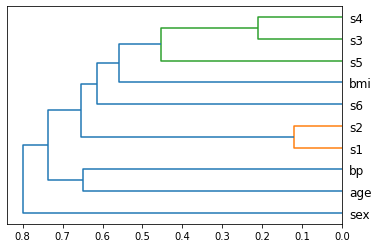

In [ ]:
ax = inspector.plot_feature_clusters()

In [ ]:
# hide
test_fig_exists(ax)

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._Inspector.permutation_importance,
    title_level=3,
    name="permutation_importance",
)

<h3 id="permutation_importance" class="doc_header"><code>permutation_importance</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L101" class="source_link" style="float:right">[source]</a></h3>

> <code>permutation_importance</code>(**`sort`**:`bool`=*`True`*, **`scoring`**=*`None`*, **`n_repeats`**=*`5`*, **`n_jobs`**=*`None`*, **`random_state`**=*`None`*, **`sample_weight`**=*`None`*, **`max_samples`**=*`1.0`*)

Calculate permutation importance

        - `sort`: Sort features by decreasing importance
        
Remaining parameters are passed to
`sklearn.inspection._permutation_importance.permutation_importance`.

In [ ]:
inspector.permutation_importance()

s5     0.496026
bmi    0.487134
bp     0.147462
s6     0.091050
s3     0.080936
age    0.074008
s2     0.062330
s1     0.053848
sex    0.024623
s4     0.023756
dtype: float64

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._Inspector.plot_permutation_importance,
    title_level=3,
    name="plot_permutation_importance",
)

<h3 id="plot_permutation_importance" class="doc_header"><code>plot_permutation_importance</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L125" class="source_link" style="float:right">[source]</a></h3>

> <code>plot_permutation_importance</code>(**`ax`**:`Optional`\[`Axes`\]=*`None`*, **`importance_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`plot_kwargs`**:`Optional`\[`dict`\]=*`None`*)

Plot a correlation matrix for `self.X` and `self.y`

Parameters:
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.
- `importance_kwargs`: kwargs to pass to
`sklearn.inspection.permutation_importance`
- `plot_kwargs`: kwargs to pass to `pd.Series.plot.barh`

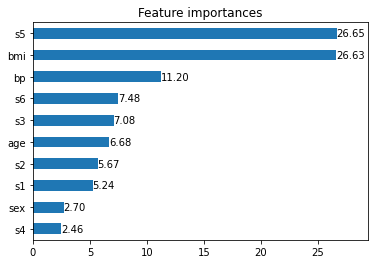

In [ ]:
ax = inspector.plot_permutation_importance(
    importance_kwargs={"scoring": "neg_mean_absolute_error"}
)

In [ ]:
test_fig_exists(ax)

## Regressors

All regression model `Inspectors` have the following methods.

In [ ]:
# hide
X_cancer, y_cancer = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

for model in REGRESSORS:
    for method in ["plot_pred_vs_act", "plot_residuals"]:
        assert hasattr(
            get_inspector(model().fit(X_cancer, y_cancer), X_cancer, y_cancer), method
        )

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._RegInspector.plot_pred_vs_act, title_level=3, name="plot_pred_vs_act"
)

<h3 id="plot_pred_vs_act" class="doc_header"><code>plot_pred_vs_act</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L355" class="source_link" style="float:right">[source]</a></h3>

> <code>plot_pred_vs_act</code>(**`ax`**:`Optional`\[`Axes`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`line_kwargs`**:`Optional`\[`dict`\]=*`None`*)

Plot predicted vs. actual values

Parameters:
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.
- `scatter_kwargs`: kwargs to pass to `plt.scatter`
- `line_kwargs`: kwargs to pass to `plt.plot`

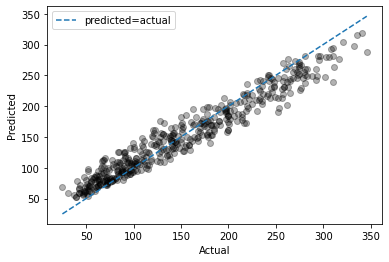

In [ ]:
ax = inspector.plot_pred_vs_act()

In [ ]:
# hide
test_fig_exists(ax)

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._RegInspector.plot_residuals, title_level=3, name="plot_residuals"
)

<h3 id="plot_residuals" class="doc_header"><code>plot_residuals</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L396" class="source_link" style="float:right">[source]</a></h3>

> <code>plot_residuals</code>(**`axes`**:`Optional`\[`array`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`line_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`hist_kwargs`**:`Optional`\[`dict`\]=*`None`*)

Plot residuals

Parameters:
- `axes`: 1D array of two Matplotlib `Axes` objects. Plot will
be added to these objects if provided; otherwise a new array of
`Axes` objects will be generated.
- `scatter_kwargs`: kwargs to pass to `plt.scatter`
- `line_kwargs`: kwargs to pass to `plt.plot` for line at y=0
- `hist_kwargs`: kwargs to pass to `plt.hist` for histogram of
residuals

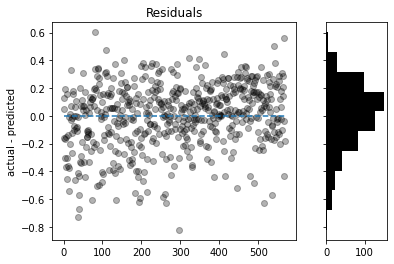

In [ ]:
X_cancer, y_cancer = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
model = LinearRegression().fit(X_cancer, y_cancer)

axes = get_inspector(model, X_cancer, y_cancer).plot_residuals()

## Classifiers

In [ ]:
# hide
X_cancer, y_cancer = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in CLASSIFIERS:
        for method in ["calculate_metrics_by_thresh", "confusion_matrix"]:
            assert hasattr(
                get_inspector(model().fit(X_iris, y_iris), X_iris, y_iris), method
            )

Every `Inspector` object for a classification model has these methods, but the details of the implementation may depend on whether the classifier is binary or multiclass.

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._BinClasInspector.calculate_metrics_by_thresh,
    title_level=3,
    name="calculate_metrics_by_thresh (binary)",
)

<h3 id="calculate_metrics_by_thresh (binary)" class="doc_header"><code>calculate_metrics_by_thresh (binary)</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L237" class="source_link" style="float:right">[source]</a></h3>

> <code>calculate_metrics_by_thresh (binary)</code>(**`metrics`**:`Union`\[`Callable`, `Sequence`\[`Callable`\]\], **`thresholds`**:`Optional`\[`Sequence`\]=*`None`*)

Calculate classification metrics as a function of threshold

Assumes that `self.model` has a `.predict_proba()` method. Uses
`self.y` as ground-truth values,
`self.model.predict_proba(self.X)[:, 1] > thresh` as
predictions.

Parameters:
- `metrics`: Callables that take `y_true`, `y_pred` as
positional arguments and return a number. Must have a `__name__`
attribute.
- `thresholds`: `Sequence` of `float` threshold values to use. By
default uses `0` and the values that appear in `y_prob[:, 1]`, which
is a minimal set that covers all of the relevant possibilities. One
reason to override that default would be to save time with a large
dataset.

Returns: DataFrame with one column "thresh" indicating the
thresholds used and an additional column for each input metric
giving the value of that metric at that threshold.

In [ ]:
X_cancer, y_cancer = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(
    X_cancer, y_cancer
)
inspector = get_inspector(
    RandomForestClassifier().fit(X_cancer_train, y_cancer_train),
    X_cancer_test,
    y_cancer_test,
)

metrics_by_thresh = inspector.calculate_metrics_by_thresh(
    metrics=[metrics.precision_score, metrics.recall_score, metrics.f1_score],
)
metrics_by_thresh.head()

 81%|████████  | 38/47 [00:00<00:00, 375.05it/s]/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 47/47 [00:00<00:00, 344.87it/s]


,thresh,precision_score,recall_score,f1_score
0,0.00,0.676923,1.0,0.807339
1,0.00,0.676923,1.0,0.807339
2,0.01,0.709677,1.0,0.830189
3,0.02,0.745763,1.0,0.854369
4,0.03,0.752137,1.0,0.858537


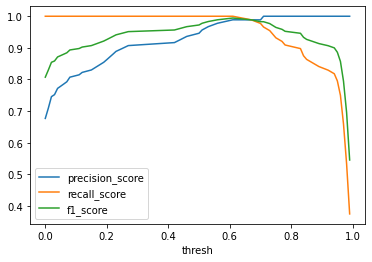

In [ ]:
ax = metrics_by_thresh.iloc[:-1].plot(x="thresh")

In [ ]:
# hide
assert (
    len(
        inspector.calculate_metrics_by_thresh(
            metrics=[metrics.precision_score], thresholds=[0.1, 0.3, 0.5, 0.7, 0.9]
        )
    )
    == 5
)

100%|██████████| 5/5 [00:00<00:00, 1036.71it/s]


In [ ]:
# hide
test_fig_exists(ax)

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._BinClasInspector.confusion_matrix,
    title_level=3,
    name="confusion_matrix (binary)",
)

<h3 id="confusion_matrix (binary)" class="doc_header"><code>confusion_matrix (binary)</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L270" class="source_link" style="float:right">[source]</a></h3>

> <code>confusion_matrix (binary)</code>(**`thresh`**:`float`=*`0.5`*, **`labels`**=*`None`*, **`sample_weight`**=*`None`*, **`normalize`**=*`None`*)

Get confusion matrix

        Assumes that `self.model` has a `.predict_proba()` method. Uses
        `self.y` as ground-truth values,
        `self.model.predict_proba(self.X)[:, 1] > thresh` as
        predictions.

        If output is not rendering properly when you reopen a notebook,
        make sure the notebook is trusted.

        Parameters:
        - `thresh`: Probability threshold for counting a prediction as
        positive
        
Remaining parameters are passed to
`sklearn.metrics._classification.confusion_matrix`.

In [ ]:
inspector.confusion_matrix(
    thresh=metrics_by_thresh.loc[metrics_by_thresh.f1_score.idxmax(), "thresh"]
)

,Predicted 0,Predicted 1,Totals
Actual 0,54,1,55
Actual 1,0,88,88
Totals,54,89,143


In [ ]:
# hide
# Make sure it works for string labels
X = pd.DataFrame({"x": [0, 0, 1, 1]})
y = pd.Series(["-", "-", "+", "+"])

get_inspector(LogisticRegression().fit(X, y), X, y).confusion_matrix()

,Predicted +,Predicted -,Totals
Actual +,2,0,2
Actual -,0,2,2
Totals,2,2,4


In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._MultiClasInspector.calculate_metrics_by_thresh,
    title_level=3,
    name="calculate_metrics_by_thresh (multiclass)",
)

<h3 id="calculate_metrics_by_thresh (multiclass)" class="doc_header"><code>calculate_metrics_by_thresh (multiclass)</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L301" class="source_link" style="float:right">[source]</a></h3>

> <code>calculate_metrics_by_thresh (multiclass)</code>(**`metrics`**:`Union`\[`Callable`, `Sequence`\[`Callable`\]\], **`thresholds`**:`Optional`\[`Sequence`\]=*`None`*)

Calculate classification metrics as a function of threshold

Assumes that `self.model` has a `.predict_proba()` method. Uses
`self.y` as ground-truth values, uses the value with the highest
probability as the prediction if that probability exceeds the
threshold, `np.nan` otherwise.

Parameters:
- `metrics`: Callables that take `y_true`, `y_pred` as
positional arguments and return a number. Must have a `__name__`
attribute and must be able to handle `np.nan` values.
- `thresholds`: `Sequence` of `float` threshold values to use. By
default uses 0 and all values that appear in `y_prob`, which is a
minimal set that covers all of the relevant possibilities. One
reason to override that default would be to save time with a large
dataset.

Returns: DataFrame with one column "thresh" indicating the
thresholds used and an additional column for each input metric
giving the value of that metric at that threshold.

In [ ]:
precision_ignoring_nan = partial(
    calculate_metric_ignoring_nan,
    metric=partial(metrics.precision_score, average="micro"),
)
precision_ignoring_nan.__name__ = "precision_ignoring_nan"

X_iris, y_iris = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(
    X_iris, y_iris, random_state=2
)
inspector = get_inspector(
    RandomForestClassifier().fit(X_iris_train.iloc[:, [3]], y_iris_train),
    X_iris_test.iloc[:, [3]],
    y_iris_test,
)

metrics_by_thresh = inspector.calculate_metrics_by_thresh(
    metrics=[coverage, precision_ignoring_nan],
)
metrics_by_thresh

  0%|          | 0/13 [00:00<?, ?it/s]/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 13/13 [00:00<00:00, 779.80it/s]


,thresh,coverage,precision_ignoring_nan
0,0.000000,1.000000,0.947368
1,0.000000,1.000000,0.947368
2,0.037851,1.000000,0.947368
3,0.053737,1.000000,0.947368
4,0.135119,1.000000,0.947368
5,0.146207,1.000000,0.947368
6,0.214291,1.000000,0.947368
7,0.785709,0.947368,0.944444
8,0.853793,0.842105,0.937500
9,0.864881,0.815789,0.935484


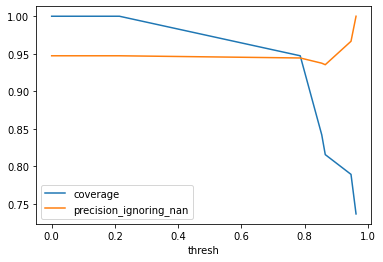

In [ ]:
ax = metrics_by_thresh.iloc[:-1].plot(x="thresh")

In [ ]:
# hide
test_fig_exists(ax)

In [ ]:
# hide
assert len(
    inspector.calculate_metrics_by_thresh(
        metrics=[coverage, precision_ignoring_nan],
        thresholds=[0, 0.25, 0.5, 0.75, 0.99],
    )
    == 5
)

  0%|          | 0/13 [00:00<?, ?it/s]/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 13/13 [00:00<00:00, 868.18it/s]


In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._MultiClasInspector.confusion_matrix,
    title_level=3,
    name="confusion_matrix (multiclass)",
)

<h3 id="confusion_matrix (multiclass)" class="doc_header"><code>confusion_matrix (multiclass)</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L333" class="source_link" style="float:right">[source]</a></h3>

> <code>confusion_matrix (multiclass)</code>(**`cmap`**=*`'PuBu'`*, **`low`**:`float`=*`0`*, **`high`**:`float`=*`0`*, **`axis`**:`Union`\[`str`, `int`, `NoneType`\]=*`0`*, **`subset`**=*`None`*, **`text_color_threshold`**:`float`=*`0.408`*, **`vmin`**:`Optional`\[`float`\]=*`None`*, **`vmax`**:`Optional`\[`float`\]=*`None`*)

Get confusion matrix

        Uses `self.y` as ground-truth values,
        `self.model.predict(self.X)` as predictions.

        If output is not rendering properly when you reopen a notebook,
        make sure the notebook is trusted.
        
Remaining parameters are passed to
`pandas.io.formats.style.background_gradient`.

In [ ]:
inspector.confusion_matrix(normalize="all")

,Predicted 0,Predicted 1,Predicted 2,Totals
Actual 0,0.421053,0.000000,0.000000,0.421053
Actual 1,0.000000,0.263158,0.026316,0.289474
Actual 2,0.000000,0.026316,0.263158,0.289474
Totals,0.421053,0.289474,0.289474,1.000000


## Linear Models

Inspectors for models that inherit from `LinearModel` or `LinearClassifierMixin` (and thus have an intercept and coefficients) have the following methods.

In [ ]:
# hide
LINEAR_MODELS = [LinearRegression, LogisticRegression, Ridge]

for model in LINEAR_MODELS:
    for method in ["show_model", "plot_coefs_vs_hparam", "plot_waterfall"]:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            assert hasattr(
                get_inspector(model().fit(X_cancer, y_cancer), X_cancer, y_cancer),
                method,
            )

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._LinRegInspector.show_model, title_level=3, name="show_model (linear model)"
)

<h3 id="show_model (linear model)" class="doc_header"><code>show_model (linear model)</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L576" class="source_link" style="float:right">[source]</a></h3>

> <code>show_model (linear model)</code>(**`intercept_formatter`**:`str`=*`'.2f'`*, **`coef_formatter`**:`str`=*`'.2f'`*)

Show model equation

Parameters:
- `intercept_formatter`: Intercept format specifier
- `coef_formatter`: Intercept format specifier

In [ ]:
inspector = get_inspector(
    LinearRegression().fit(X_diabetes, y_diabetes), X_diabetes, y_diabetes
)

inspector.show_model()

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer, y_cancer), X_cancer, y_cancer
)

inspector.show_model()

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_iris, y_iris), X_iris, y_iris
)

inspector.show_model()

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._LinRegInspector.plot_coefs_vs_hparam,
    title_level=3,
    name="plot_coefs_vs_hparam",
)

<h3 id="plot_coefs_vs_hparam" class="doc_header"><code>plot_coefs_vs_hparam</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L506" class="source_link" style="float:right">[source]</a></h3>

> <code>plot_coefs_vs_hparam</code>(**`hparam`**:`str`, **`vals`**:`Sequence`\[`float`\])

Plot coefficient values against a hyperparameter

Parameters:
- `hparam`: Name of hyperparameter; must be an attribute of
`self.model`
- `vals`: Values of that hyperparameter to use

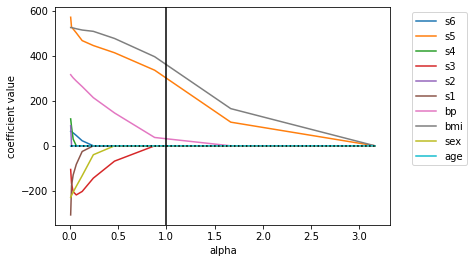

In [ ]:
inspector = get_inspector(Lasso().fit(X_diabetes, y_diabetes), X_diabetes, y_diabetes)

ax = inspector.plot_coefs_vs_hparam("alpha", np.logspace(-2, 0.5, 10))

In [ ]:
# hide
test_fig_exists(ax)

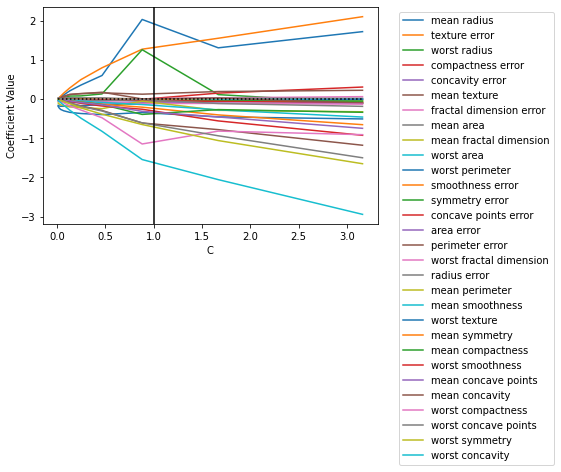

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer, y_cancer), X_cancer, y_cancer
)

ax = inspector.plot_coefs_vs_hparam("C", np.logspace(-2, 0.5, 10))

In [ ]:
# hide
test_fig_exists(ax)

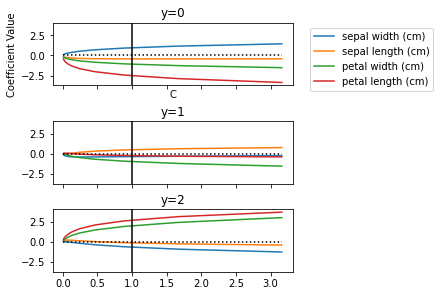

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_iris, y_iris), X_iris, y_iris
)

axes = inspector.plot_coefs_vs_hparam("C", np.logspace(-2, 0.5, 10))

In [ ]:
# hide
test_fig_exists(axes[0])

This method is defined for linear regression and binary logistic regression models but not for multiclass logistic regression models.

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._LinRegInspector.plot_waterfall,
    title_level=3,
    name="plot_waterfall (regression or binary linear model)",
)

<h3 id="plot_waterfall (regression or binary linear model)" class="doc_header"><code>plot_waterfall (regression or binary linear model)</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L534" class="source_link" style="float:right">[source]</a></h3>

> <code>plot_waterfall (regression or binary linear model)</code>(**`item`**:`Union`\[`Series`, `array`\], **`bar_num_formatter`**:`str`=*`'.1f'`*, **`tick_num_formatter`**:`str`=*`'.2f'`*, **`sorted_value`**=*`True`*, **`threshold`**=*`0.01`*, **`blue_color`**=*`'#377eb8'`*, **`green_color`**=*`'#4daf4a'`*, **`red_color`**=*`'#ff7f00'`*, **`Title`**=*`''`*, **`x_lab`**=*`''`*, **`y_lab`**=*`''`*, **`formatting`**=*`'{:,.1f}'`*, **`other_label`**=*`'other'`*, **`net_label`**=*`'net'`*, **`rotation_value`**=*`30`*)

Make a waterfall chart showing how each feature contributes
        to the prediction for the input item.

        Parameters:
        - `item`: Input item, with the same shape and value meanings as
        a single row from `self.X`
        - `bar_num_formatter`: Bar label format specifier
        - `tick_num_formatter`: Tick label format specifier

        Additional keyword arguments will be passed to
        `waterfall_chart.plot`
        
Remaining parameters are passed to
`waterfall_chart.plot`.

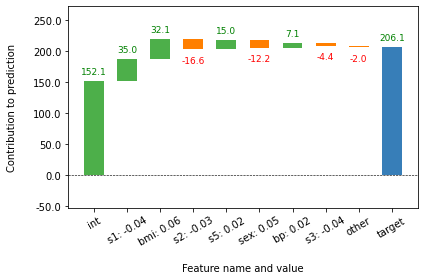

In [ ]:
inspector = get_inspector(
    LinearRegression().fit(X_diabetes, y_diabetes), X_diabetes, y_diabetes
)

ax = inspector.plot_waterfall(X_diabetes.iloc[0])

In [ ]:
# hide
test_fig_exists(ax)

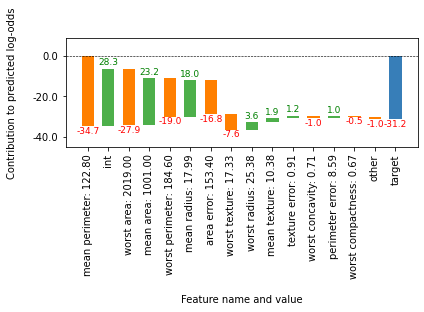

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer, y_cancer), X_cancer, y_cancer
)

ax = inspector.plot_waterfall(X_cancer.iloc[0], rotation_value=90)
test_fig_exists(ax)

In [ ]:
# hide
test_fig_exists(ax)

## Decision Tree Models

In [ ]:
# hide
from sklearn.tree import ExtraTreeClassifier, ExtraTreeRegressor

TREE_MODELS = [
    DecisionTreeClassifier,
    DecisionTreeRegressor,
    ExtraTreeClassifier,
    ExtraTreeRegressor,
]

for model in TREE_MODELS:
    for method in ["show_model"]:
        assert hasattr(
            get_inspector(model().fit(X_iris, y_iris), X_iris, y_iris), method
        )

All decision tree model inspectors have the following methods.

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._TreeRegInspector.show_model, title_level=3, name="show_model (tree model)"
)

<h3 id="show_model (tree model)" class="doc_header"><code>show_model (tree model)</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L766" class="source_link" style="float:right">[source]</a></h3>

> <code>show_model (tree model)</code>(**`ax`**:`Optional`\[`Axes`\]=*`None`*, **`max_depth`**=*`None`*, **`feature_names`**=*`None`*, **`class_names`**=*`None`*, **`label`**=*`'all'`*, **`filled`**=*`False`*, **`impurity`**=*`True`*, **`node_ids`**=*`False`*, **`proportion`**=*`False`*, **`rounded`**=*`False`*, **`precision`**=*`3`*, **`fontsize`**=*`None`*)

Show decision tree
Remaining parameters are passed to
`sklearn.tree._export.plot_tree`.

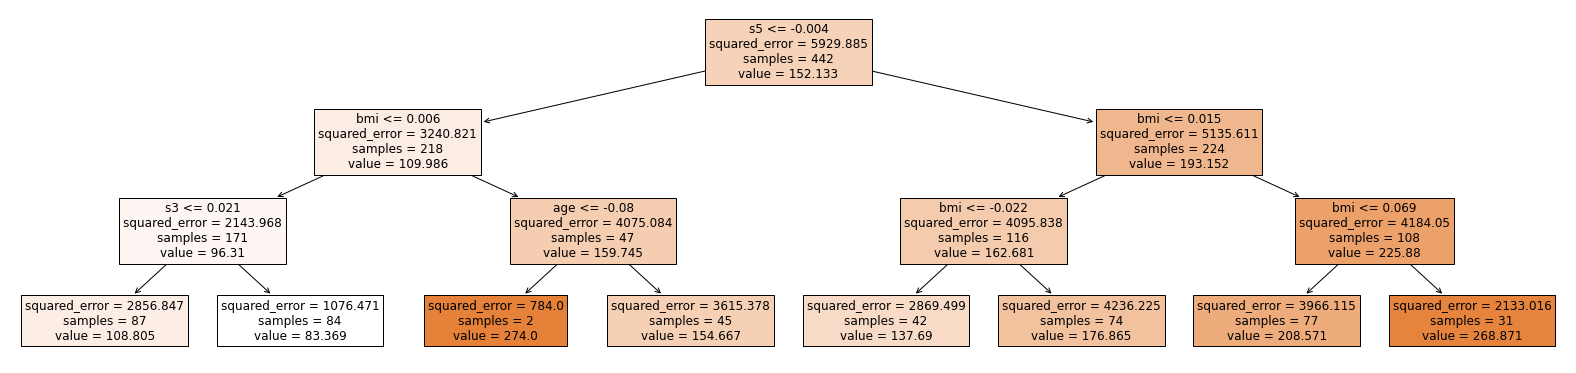

In [ ]:
ax = get_inspector(
    DecisionTreeRegressor(max_depth=3).fit(X_diabetes, y_diabetes),
    X_diabetes,
    y_diabetes,
).show_model()

In [ ]:
# hide
test_fig_exists(ax)

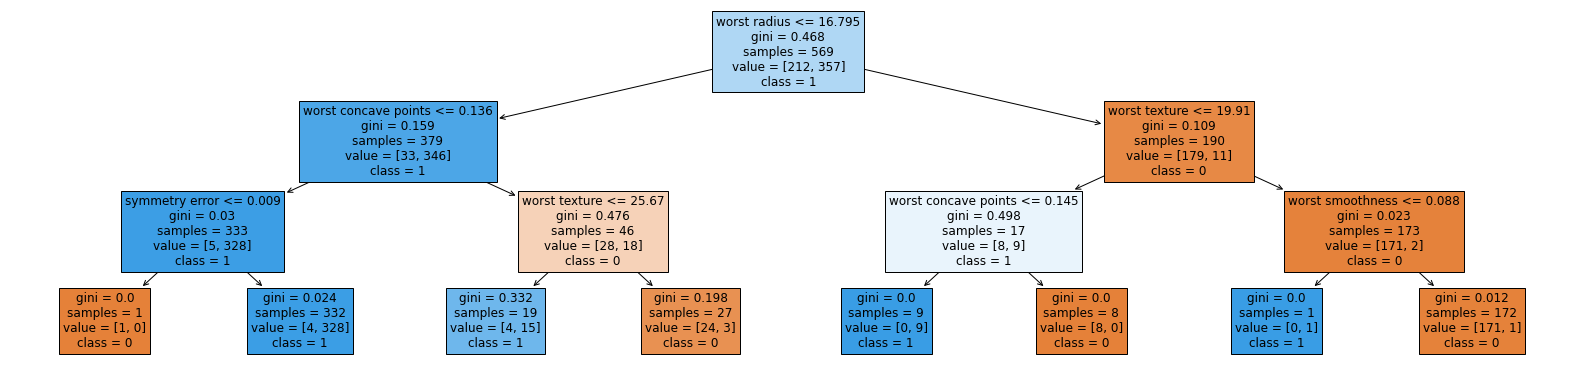

In [ ]:
ax = get_inspector(
    DecisionTreeClassifier(max_depth=3).fit(X_cancer, y_cancer), X_cancer, y_cancer
).show_model()

In [ ]:
# hide
test_fig_exists(ax)

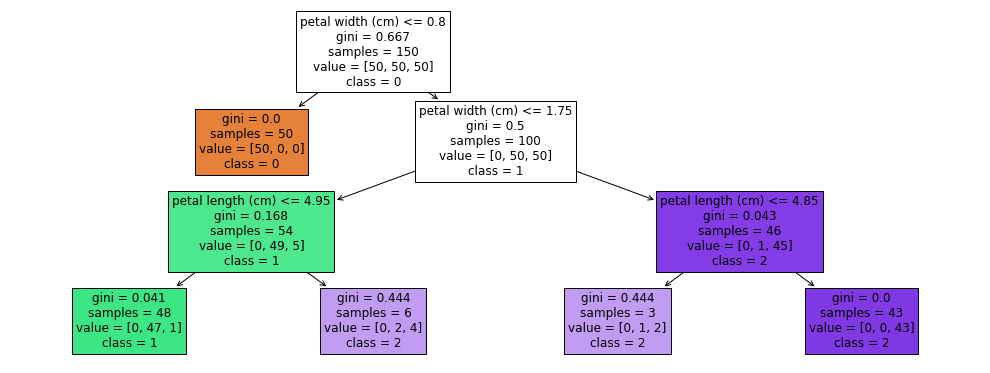

In [ ]:
ax = get_inspector(
    DecisionTreeClassifier(max_depth=3, random_state=2).fit(X_iris, y_iris),
    X_iris,
    y_iris,
).show_model()

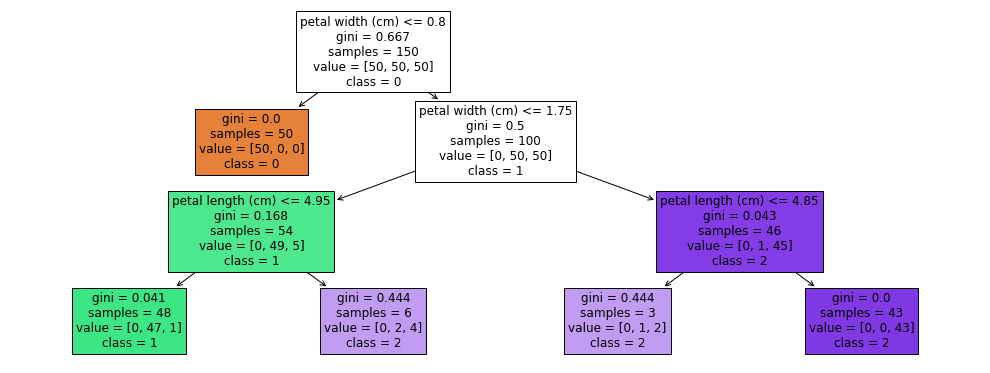

In [ ]:
# hide
import os

import matplotlib.testing.compare

"Make sure tree diagram is invariant to data ordering"
ax2 = get_inspector(
    DecisionTreeClassifier(max_depth=3, random_state=2).fit(X_iris[::-1], y_iris[::-1]),
    X_iris[::-1],
    y_iris[::-1],
).show_model()

ax.get_figure().savefig("tmp1.png")
ax2.get_figure().savefig("tmp2.png")

assert matplotlib.testing.compare.compare_images("tmp1.png", "tmp2.png", 1e-7) is None
os.remove("tmp1.png")
os.remove("tmp2.png")

In [ ]:
# hide
test_fig_exists(ax)

## SearchCV Models

In [ ]:
# hide
SEARCH_MODELS = [GridSearchCV]

for model in SEARCH_MODELS:
    for estimator in CLASSIFIERS[:2] + REGRESSORS[:2]:
        for method in ["plot_scores_vs_hparam", "show_score_vs_hparam_pair"]:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                assert hasattr(
                    get_inspector(
                        model(estimator(), param_grid={}, cv=2).fit(X_iris, y_iris),
                        X_iris,
                        y_iris,
                    ),
                    method,
                )

Inspectors for models that inherit from `BaseSearchCV` have the following methods.

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._SearchInspector.plot_scores_vs_hparam,
    title_level=3,
    name="plot_scores_vs_hparam",
)

<h3 id="plot_scores_vs_hparam" class="doc_header"><code>plot_scores_vs_hparam</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L816" class="source_link" style="float:right">[source]</a></h3>

> <code>plot_scores_vs_hparam</code>(**`hparam`**:`Optional`\[`str`\]=*`None`*, **`score_cols`**:`Union`\[`str`, `List`\[`str`\], `NoneType`\]=*`None`*, **`ax`**=*`None`*)

Plot model scores against values of one hyperparameter

Parameters:
- `hparam`: Name of the hyperparameter to plot against. Must be
provided if there are multiple hyperparameters. Any other
hyperparameters will be fixed at the value they have in
`self.model.best_params_`.
- `score_cols`: Name of score columns to plot. By default will
be the mean test and (if present) train score for the primary
scoring metric.
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

In [ ]:
grid = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=3),
    param_grid={"min_samples_leaf": (1, 2, 5, 10, 20, 50)},
    n_jobs=-1,
    return_train_score=True,
    cv=KFold(5, shuffle=True, random_state=3),
)
grid.fit(X_cancer, y_cancer)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=3), n_jobs=-1,
             param_grid={'min_samples_leaf': (1, 2, 5, 10, 20, 50)},
             return_train_score=True)

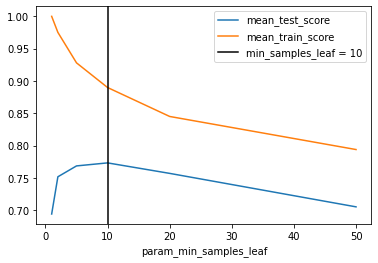

In [ ]:
ax = get_inspector(grid, X_cancer, y_cancer).plot_scores_vs_hparam()

In [ ]:
# hide
test_fig_exists(ax)

In [ ]:
grid = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=3),
    param_grid={"min_samples_leaf": (1, 2, 5, 10, 20, 50)},
    n_jobs=-1,
    return_train_score=False,
    cv=KFold(5, shuffle=True, random_state=3),
)
grid.fit(X_cancer, y_cancer)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=3), n_jobs=-1,
             param_grid={'min_samples_leaf': (1, 2, 5, 10, 20, 50)})

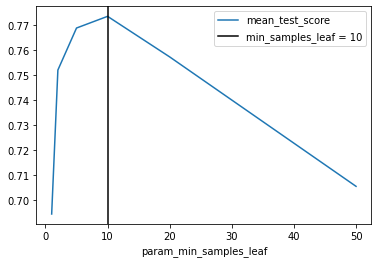

In [ ]:
ax = get_inspector(grid, X_cancer, y_cancer).plot_scores_vs_hparam()

In [ ]:
# hide
test_fig_exists(ax)

In [ ]:
grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=3),
    param_grid={
        "min_samples_leaf": (1, 2, 5),
        "max_features": (0.5, 0.3, 0.1),
    },
    n_jobs=-1,
    return_train_score=True,
    cv=KFold(5, shuffle=True, random_state=3),
)
grid.fit(X_cancer, y_cancer)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=RandomForestRegressor(random_state=3), n_jobs=-1,
             param_grid={'max_features': (0.5, 0.3, 0.1),
                         'min_samples_leaf': (1, 2, 5)},
             return_train_score=True)

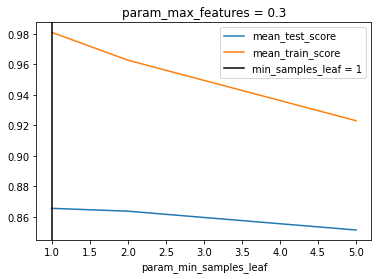

In [ ]:
inspector = get_inspector(grid, X_cancer, y_cancer)
ax = inspector.plot_scores_vs_hparam("min_samples_leaf")

In [ ]:
# hide
test_fig_exists(ax)

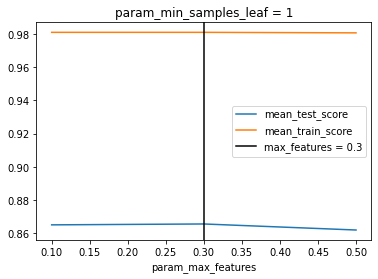

In [ ]:
ax = inspector.plot_scores_vs_hparam("max_features")

In [ ]:
# hide
test_fig_exists(ax)

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._SearchInspector.show_score_vs_hparam_pair,
    title_level=3,
    name="show_score_vs_hparam_pair",
)

<h3 id="show_score_vs_hparam_pair" class="doc_header"><code>show_score_vs_hparam_pair</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L899" class="source_link" style="float:right">[source]</a></h3>

> <code>show_score_vs_hparam_pair</code>(**`hparams`**=*`None`*, **`score_col`**=*`None`*, **`cmap`**=*`'PuBu'`*, **`low`**:`float`=*`0`*, **`high`**:`float`=*`0`*, **`axis`**:`Union`\[`str`, `int`, `NoneType`\]=*`0`*, **`subset`**=*`None`*, **`text_color_threshold`**:`float`=*`0.408`*, **`vmin`**:`Optional`\[`float`\]=*`None`*, **`vmax`**:`Optional`\[`float`\]=*`None`*)

Show model scores against a pair of hyperparameters

        Background gradient uses `axis=None` by default, to facilitate
        identifying the best score across all combinations of
        hyperparameter values.

        Parameters:
        - `hparams`: Name of the hyperparameters to plot against.
        The first two hyperparameters in `self.model.param_grid` will be
        used by default. Any other hyperparameters will be fixed at the
        value they have in `self.model.best_params_`.
        - `score_col`: Name of score column to plot. By default will
        be the mean test score for the primary scoring metric.
        
Remaining parameters are passed to
`pandas.io.formats.style.background_gradient`.

In [ ]:
inspector.show_score_vs_hparam_pair()

param_min_samples_leaf,1,2,5
param_max_features,,,
0.1,0.865075,0.860644,0.842908
0.3,0.865606,0.863742,0.851389
0.5,0.861970,0.858181,0.852765


In [ ]:
inspector.show_score_vs_hparam_pair(axis="columns")

param_min_samples_leaf,1,2,5
param_max_features,,,
0.1,0.865075,0.860644,0.842908
0.3,0.865606,0.863742,0.851389
0.5,0.861970,0.858181,0.852765


In [ ]:
inspector.show_score_vs_hparam_pair(axis="rows")

param_min_samples_leaf,1,2,5
param_max_features,,,
0.1,0.865075,0.860644,0.842908
0.3,0.865606,0.863742,0.851389
0.5,0.861970,0.858181,0.852765


In [ ]:
grid = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid={
        "min_samples_leaf": (1, 2, 5, 10, 20, 50),
        "max_features": (0.3, 0.5, 1.0),
        "splitter": ("best", "random"),
    },
    n_jobs=-1,
    return_train_score=True,
    cv=KFold(5, shuffle=True),
)
grid.fit(X_cancer, y_cancer)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_features': (0.3, 0.5, 1.0),
                         'min_samples_leaf': (1, 2, 5, 10, 20, 50),
                         'splitter': ('best', 'random')},
             return_train_score=True)

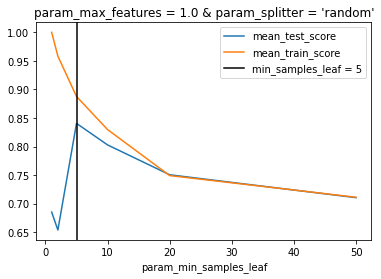

In [ ]:
inspector = get_inspector(grid, X_cancer, y_cancer)
ax = inspector.plot_scores_vs_hparam("min_samples_leaf")

In [ ]:
# hide
test_fig_exists(ax)

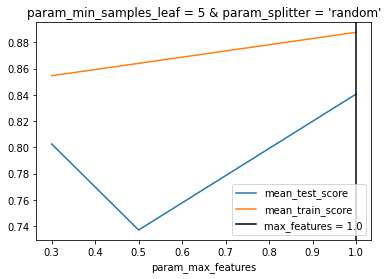

In [ ]:
inspector = get_inspector(grid, X_cancer, y_cancer)
ax = inspector.plot_scores_vs_hparam("max_features")

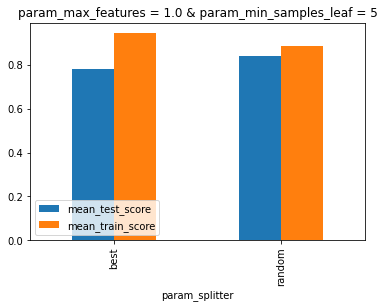

In [ ]:
ax = inspector.plot_scores_vs_hparam("splitter")
ax.legend(loc="lower left");

In [ ]:
# hide
test_fig_exists(ax)

In [ ]:
inspector.show_score_vs_hparam_pair(["min_samples_leaf", "max_features"])

param_max_features,0.3,0.5,1.0
param_min_samples_leaf,,,
1,0.655341,0.703061,0.690144
2,0.727984,0.700682,0.688368
5,0.794122,0.768058,0.811497
10,0.751218,0.728595,0.786612
20,0.719979,0.733451,0.756194
50,0.641183,0.649738,0.707742


Inspector objects for SearchCV models with one or two features have appropriate plotting methods.

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


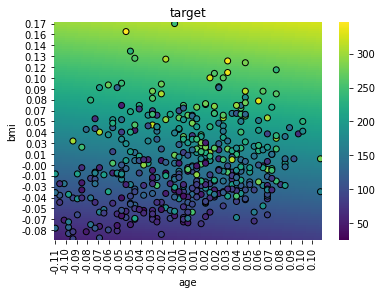

In [ ]:
grid = GridSearchCV(
    estimator=LinearRegression(),
    param_grid={},
    n_jobs=-1,
    return_train_score=True,
    cv=KFold(5, shuffle=True),
)
ax = get_inspector(
    grid.fit(X_diabetes.iloc[:, [0, 2]], y_diabetes),
    X_diabetes.iloc[:, [0, 2]],
    y_diabetes,
).plot()

## Models with One Feature

In [ ]:
# hide
for model in CLASSIFIERS + REGRESSORS:
    for method in ["plot"]:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            assert hasattr(
                get_inspector(
                    model().fit(X_iris.iloc[:, :1], y_iris),
                    X_iris.iloc[:, :1],
                    y_iris,
                ),
                method,
            )

An `Inspector` for any model with one feature has a `plot` method. The interface is slightly different for binary models than for multiclass or regression models.

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._Bin1dPlotter.plot, title_level=3, name="plot (single-feature binary model)"
)

<h3 id="plot (single-feature binary model)" class="doc_header"><code>plot (single-feature binary model)</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L1002" class="source_link" style="float:right">[source]</a></h3>

> <code>plot (single-feature binary model)</code>(**`thresh`**:`float`=*`0.5`*, **`plot_data`**:`bool`=*`True`*, **`ax`**:`Optional`\[`Axes`\]=*`None`*, **`prob_line_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`thresh_line_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs_correct`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs_incorrect`**:`Optional`\[`dict`\]=*`None`*)

Plot predictions from a binary classification model that
provides probabilities and has a single input

Parameters:
- `thresh`: Probability threshold for counting a prediction as
positive
- `plot_data`: Make a scatter plot of the data
- `ax`: Matplotlib `Axes` object. Plot will be added to this
object if provided; otherwise a new `Axes` object will be
generated.
- `prob_line_kwargs`: kwargs to pass to `ax.plot` for plotting
model probabilities
- `thresh_line_kwargs`: kwargs to pass to `ax.plot` for plotting
threshold
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting
all data points
- `scatter_kwargs_correct`: kwargs to pass to `ax.scatter` for
plotting data points that the model predicted correctly.
Overrides `scatter_kwargs`.
- `scatter_kwargs_incorrect`: kwargs to pass to `ax.scatter` for
plotting data points that the model predicted incorrectly.
Overrides `scatter_kwargs`.

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


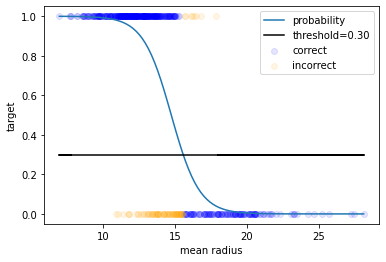

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer.iloc[:, [0]], y_cancer),
    X_cancer.iloc[:, [0]],
    y_cancer,
)

ax = inspector.plot(thresh=0.3, scatter_kwargs={"alpha": 0.1})

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


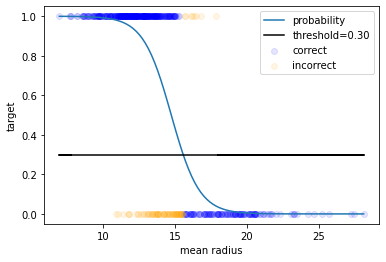

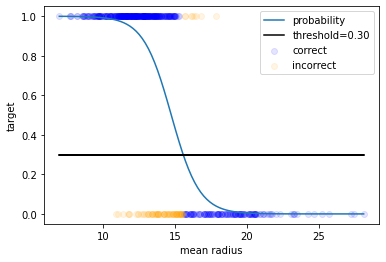

In [ ]:
# hide
# Test for images being the same is failing, but they look the same to
# me. Might be an issue of plotting order.
"Make sure plot is invariant to order"
y_cancer_str = y_cancer.map({0: "no", 1: "yes"})

inspector1 = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer.iloc[:, [0]], y_cancer_str),
    X_cancer.iloc[:, [0]],
    y_cancer_str,
)

ax1 = inspector1.plot(thresh=0.3, scatter_kwargs={"alpha": 0.1})

inspector2 = get_inspector(
    LogisticRegression(max_iter=10_000).fit(
        X_cancer.iloc[:, [0]][::-1], y_cancer_str[::-1]
    ),
    X_cancer.iloc[:, [0]][::-1],
    y_cancer_str[::-1],
)

ax2 = inspector2.plot(thresh=0.3, scatter_kwargs={"alpha": 0.1})

In [ ]:
# hide
test_fig_exists(ax)

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._Reg1dPlotter.plot,
    title_level=3,
    name="plot (single-feature regression or multiclass model)",
)

<h3 id="plot (single-feature regression or multiclass model)" class="doc_header"><code>plot (single-feature regression or multiclass model)</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L954" class="source_link" style="float:right">[source]</a></h3>

> <code>plot (single-feature regression or multiclass model)</code>(**`plot_data`**:`bool`=*`True`*, **`ax`**:`Optional`\[`Axes`\]=*`None`*, **`line_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*)

Plot predictions from a regression model with a single input

Parameters:
- `plot_data`: Make a scatter plot of the data
- `line_kwargs`: kwargs to pass to `ax.plot` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

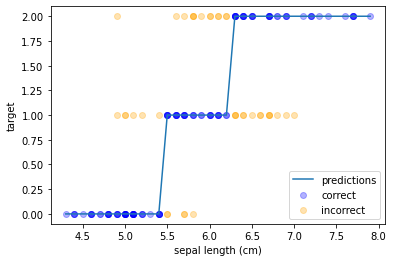

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_iris.iloc[:, :1], y_iris),
    X_iris.iloc[:, :1],
    y_iris,
)

ax = inspector.plot()

In [ ]:
# hide
test_fig_exists(ax)

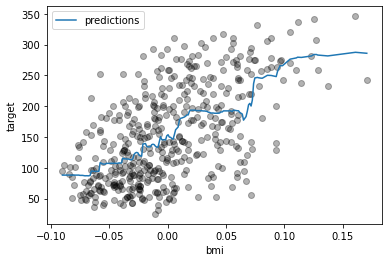

In [ ]:
rfr = RandomForestRegressor(max_depth=3).fit(X_diabetes.loc[:, ["bmi"]], y_diabetes)
ax = get_inspector(
    rfr,
    X_diabetes.loc[:, ["bmi"]],
    y_diabetes,
).plot()

In [ ]:
# hide
test_fig_exists(ax)

Here is the same random forest along with some of its constituent decision trees:

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but DecisionTree

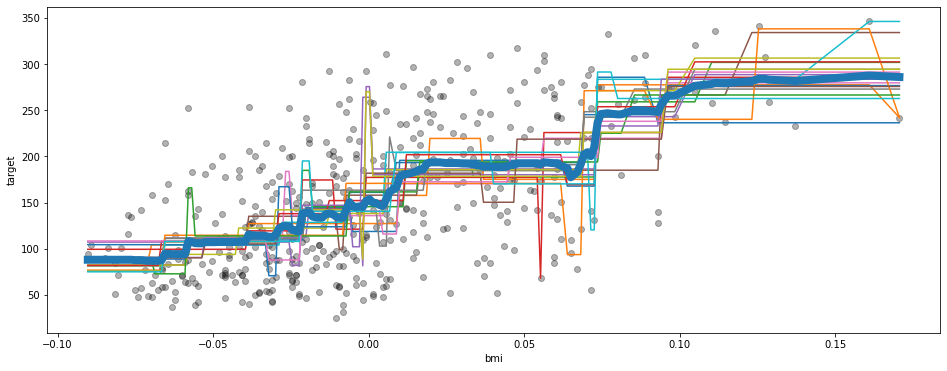

In [ ]:
inspector = get_inspector(
    rfr,
    X_diabetes.loc[:, ["bmi"]],
    y_diabetes,
)
fig, ax = plt.subplots(figsize=(16, 6))
for estimator in rfr.estimators_[:20]:
    get_inspector(estimator, X_diabetes.loc[:, ["bmi"]], y_diabetes).plot(
        ax=ax, plot_data=False
    )
ax = inspector.plot(ax=ax, line_kwargs={"linewidth": 8})
ax.get_legend().remove()

In [ ]:
# hide
test_fig_exists(ax)

## Models with Two Features

In [ ]:
# hide
for model in CLASSIFIERS + REGRESSORS:
    for method in ["plot", "plot3d"]:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            assert hasattr(
                get_inspector(
                    model().fit(X_iris.iloc[:, :2], y_iris),
                    X_iris.iloc[:, :2],
                    y_iris,
                ),
                method,
            )

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(
/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(
/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.

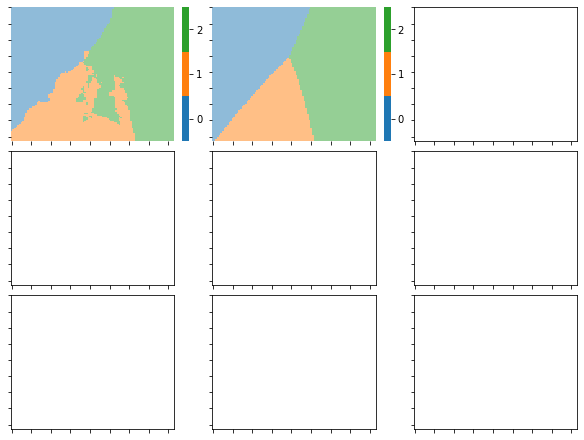

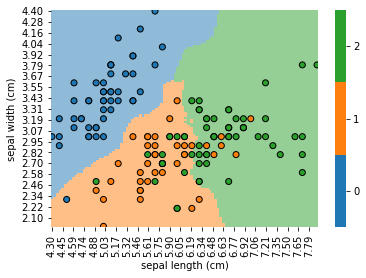

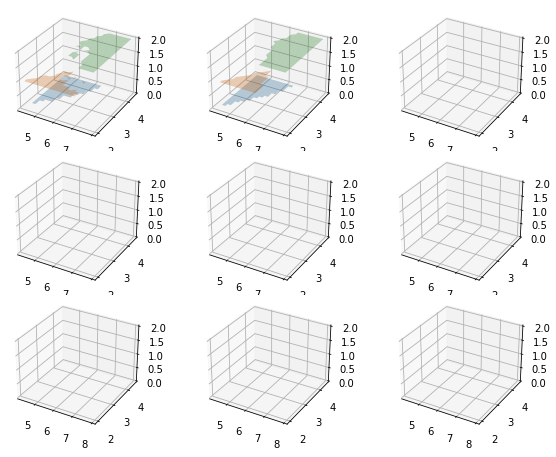

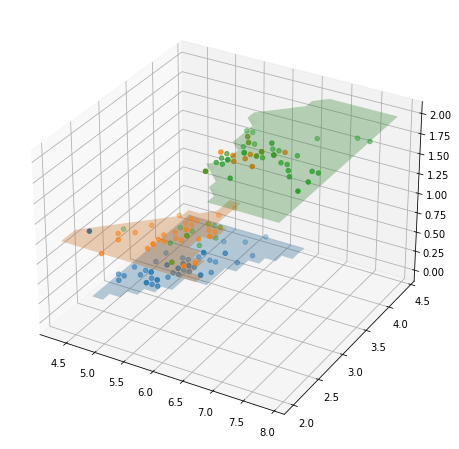

In [ ]:
# hide
from sklearn.ensemble import (
    AdaBoostClassifier,
    AdaBoostRegressor,
    BaggingClassifier,
    BaggingRegressor,
    ExtraTreesClassifier,
    ExtraTreesRegressor,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
    StackingClassifier,
)

ENSEMBLES = [
    AdaBoostClassifier,
    AdaBoostRegressor,
    BaggingClassifier,
    BaggingRegressor,
    ExtraTreesClassifier,
    ExtraTreesRegressor,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
]

for model in ENSEMBLES:
    for method in ["plot_components", "plot_components3d"]:
        assert hasattr(
            get_inspector(
                model(n_estimators=2).fit(X_iris.iloc[:, :2], y_iris),
                X_iris.iloc[:, :2],
                y_iris,
            ),
            method,
        )

inspector = get_inspector(
    StackingClassifier(
        estimators=[(estimator.__name__, estimator()) for estimator in CLASSIFIERS[1:3]]
    ).fit(X_iris.iloc[:, :2], y_iris),
    X_iris.iloc[:, :2],
    y_iris,
)
inspector.plot_components()
inspector.plot()
inspector.plot_components3d()
inspector.plot3d();

An `Inspector` for any model with two features also has a `plot` method.

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._Reg2dPlotter.plot, title_level=3, name="plot (two-feature model)"
)

<h3 id="plot (two-feature model)" class="doc_header"><code>plot (two-feature model)</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L1215" class="source_link" style="float:right">[source]</a></h3>

> <code>plot (two-feature model)</code>(**`plot_data`**:`bool`=*`True`*, **`tick_formatter`**:`Optional`\[`str`\]=*`'.2f'`*, **`ax`**:`Axes`=*`None`*, **`heatmap_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*)

Plot predictions from a model with two inputs as a heatmap.

Parameters:
- `plot_data`: Make a scatter plot of the data
- `tick_formatter`: Tick label format specifier
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.
- `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


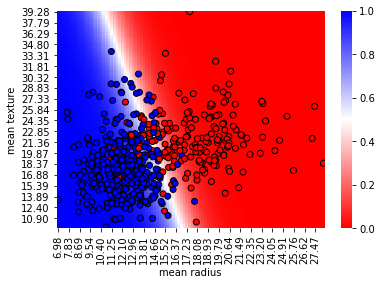

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer.iloc[:, :2], y_cancer),
    X_cancer.iloc[:, :2],
    y_cancer,
)

ax = inspector.plot()

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


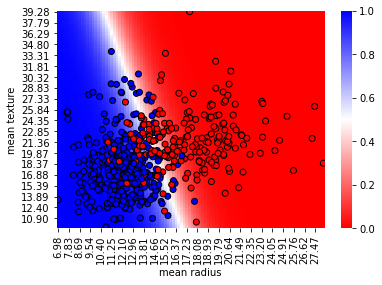

In [ ]:
# hide
# result looks a little different because of plotting order, but
# otherwise it is the same
"Make sure plot is invariant to order"
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer.iloc[:, :2][::-1], y_cancer[::-1]),
    X_cancer.iloc[:, :2][::-1],
    y_cancer[::-1],
)

ax2 = inspector.plot()

In [ ]:
# hide
test_fig_exists(ax)

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


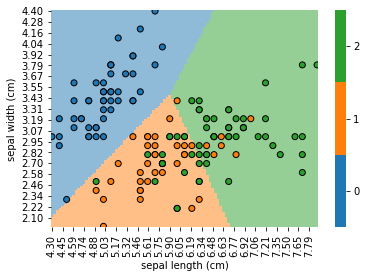

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_iris.iloc[:, :2], y_iris),
    X_iris.iloc[:, :2],
    y_iris,
)

ax = inspector.plot()

In [ ]:
# hide
# It's not completely invariant because plotting order is different, but
# it's essentially the same
"Make sure plot is invariant to order"
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_iris.iloc[:, :2][::-1], y_iris[::-1]),
    X_iris.iloc[:, :2][::-1],
    y_iris[::-1],
)

In [ ]:
# hide
test_fig_exists(ax)

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


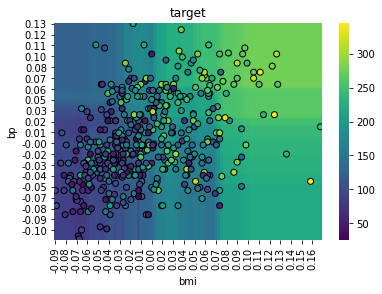

In [ ]:
rfr = RandomForestRegressor(min_samples_leaf=9).fit(
    X_diabetes.loc[:, ["bmi", "bp"]], y_diabetes
)
inspector = get_inspector(
    rfr,
    X_diabetes.loc[:, ["bmi", "bp"]],
    y_diabetes,
)

ax = inspector.plot()

In [ ]:
# hide
test_fig_exists(ax)

You can fit a model on a training set and then generate an inspector for the test set to inspect overfitting.

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


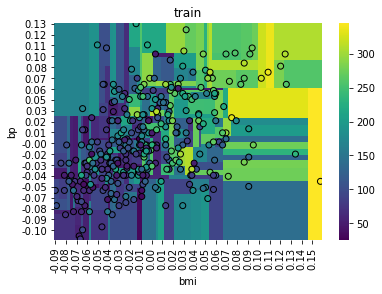

In [ ]:
X_diabetes_train, X_diabetes_test, y_diabetes_train, y_diabetes_test = train_test_split(
    X_diabetes, y_diabetes, random_state=2
)

dtr = DecisionTreeRegressor().fit(
    X_diabetes_train.loc[:, ["bmi", "bp"]], y_diabetes_train
)
inspector_train = get_inspector(
    dtr,
    X_diabetes_train.loc[:, ["bmi", "bp"]],
    y_diabetes_train,
)
ax = inspector_train.plot()
ax.set(title="train");

In [ ]:
# hide
test_fig_exists(ax)

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


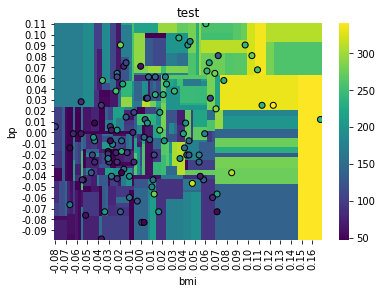

In [ ]:
inspector_test = get_inspector(
    dtr,
    X_diabetes_test.loc[:, ["bmi", "bp"]],
    y_diabetes_test,
)
ax = inspector_test.plot()
ax.set(title="test");

In [ ]:
# hide
test_fig_exists(ax)

An `Inspector` for a model with two features also has a `plot3d` method. The interface is slightly different for binary models than for multiclass or regression models.

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._Bin2dPlotter.plot3d, title_level=3, name="plot3d (binary model)"
)

<h3 id="plot3d (binary model)" class="doc_header"><code>plot3d (binary model)</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L1472" class="source_link" style="float:right">[source]</a></h3>

> <code>plot3d (binary model)</code>(**`thresh`**=*`0.5`*, **`plot_prob`**:`bool`=*`True`*, **`plot_thresh`**:`bool`=*`True`*, **`plot_data`**:`bool`=*`True`*, **`ax`**:`Axes`=*`None`*, **`prob_surf_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`thresh_surf_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*)

Plot data and predictions in 3D

Best viewed with a tool such as https://github.com/matplotlib/ipympl
that supports rotating the output

Parameters:
- `thresh`: Probability threshold for counting a prediction as
positive
- `plot_prob`: Whether to plot the model probabilities
- `plot_thresh`: Whether to plot a classification threshold
- `plot_data`: Whether to plot the data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.
- `prob_surf_kwargs`: kwargs to pass to the model probability
surface
- `thresh_surf_kwargs`: kwargs to pass to the threshold surface
- `scatter_kwargs`: kwargs to pass to the scatter plot of the data

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


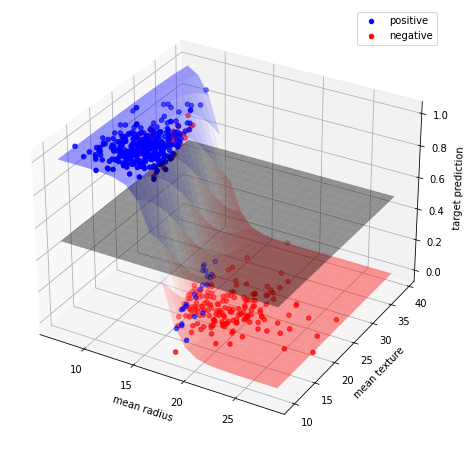

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer.iloc[:, :2], y_cancer),
    X_cancer.iloc[:, :2],
    y_cancer,
)

ax = inspector.plot3d()

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


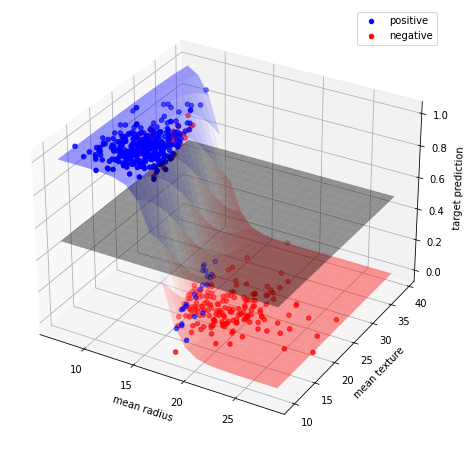

In [ ]:
# hide
"Make sure method is order invariant, can handle string target values"
y_cancer_str = y_cancer.map({0: "no", 1: "yes"})

inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(
        X_cancer.iloc[:, :2][::-1], y_cancer_str[::-1]
    ),
    X_cancer.iloc[:, :2][::-1],
    y_cancer_str[::-1],
)

ax2 = inspector.plot3d()

ax.get_figure().savefig("tmp1.png")
ax2.get_figure().savefig("tmp2.png")

assert matplotlib.testing.compare.compare_images("tmp1.png", "tmp2.png", 1e-7) is None
os.remove("tmp1.png")
os.remove("tmp2.png")

In [ ]:
# hide
test_fig_exists(ax)

An interactive tool such as [ipyml](https://github.com/matplotlib/ipympl) makes it easier to see depth in these 3D plots:

In [ ]:
from IPython.display import Video

Video(
    "https://github.com/gsganden/model_inspector/blob/master/docs/regression_3d.mov?raw=true"  # noqa: E501
)

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._Reg2dPlotter.plot3d,
    title_level=3,
    name="plot3d (two-feature regression or multiclass model)",
)

<h3 id="plot3d (two-feature regression or multiclass model)" class="doc_header"><code>plot3d (two-feature regression or multiclass model)</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L1277" class="source_link" style="float:right">[source]</a></h3>

> <code>plot3d (two-feature regression or multiclass model)</code>(**`plot_data`**:`bool`=*`True`*, **`ax`**:`Axes`=*`None`*, **`surf_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*)

Plot data and predictions in 3d

Best viewed with a tool such as https://github.com/matplotlib/ipympl
that supports rotating the output

Parameters:
- `plot_data`: Make a scatter plot of the data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.
- `surf_kwargs`: kwargs to pass to `ax.plot_surface` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


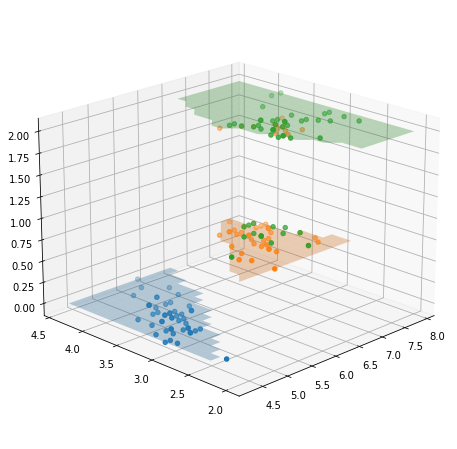

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_iris.iloc[:, :2], y_iris),
    X_iris.iloc[:, :2],
    y_iris,
)

ax = inspector.plot3d()
ax.view_init(elev=20, azim=225)

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


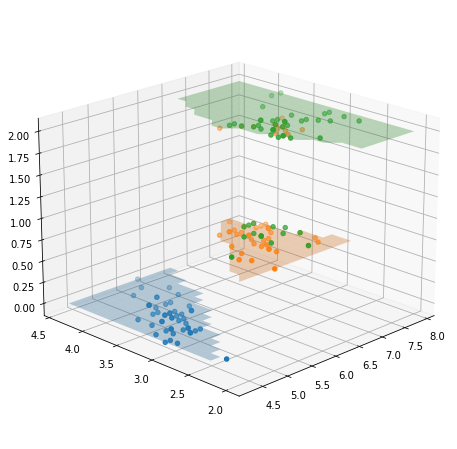

In [ ]:
# hide
"Make sure plotting is invariant to order"
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_iris.iloc[:, :2][::-1], y_iris[::-1]),
    X_iris.iloc[:, :2][::-1],
    y_iris[::-1],
)

ax2 = inspector.plot3d()
ax2.view_init(elev=20, azim=225)

ax2.get_figure().savefig("tmp1.png")
ax2.get_figure().savefig("tmp2.png")

assert matplotlib.testing.compare.compare_images("tmp1.png", "tmp2.png", 1e-7) is None
os.remove("tmp1.png")
os.remove("tmp2.png")

In [ ]:
# hide
test_fig_exists(ax)

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


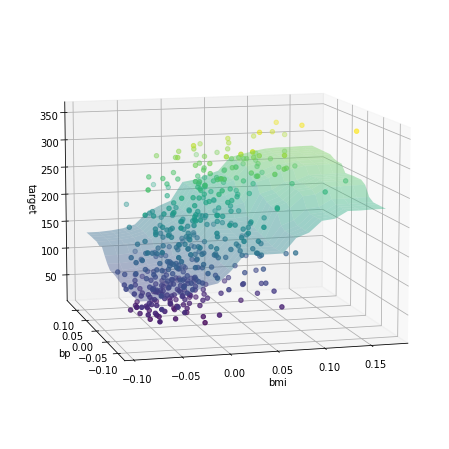

In [ ]:
inspector = get_inspector(
    RandomForestRegressor(max_depth=3).fit(
        X_diabetes.loc[:, ["bmi", "bp"]], y_diabetes
    ),
    X_diabetes.loc[:, ["bmi", "bp"]],
    y_diabetes,
)

ax = inspector.plot3d()
ax.view_init(elev=10.0, azim=255)

In [ ]:
# hide
test_fig_exists(ax)

### Ensemble Models With Two Features

Ensemble models with an `.estimators_` attribute that have two features also have a `.plot_components()` method. (There is no analogous method for models with one feature because plotting the component estimators along with the ensemble yourself is relatively easy in that case and makes it easier to customize the result.)

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._2dMultiPlotterMixin.plot_components, title_level=4, name="plot_components"
)

<h4 id="plot_components" class="doc_header"><code>plot_components</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L1340" class="source_link" style="float:right">[source]</a></h4>

> <code>plot_components</code>(**`axes`**=*`None`*, **\*\*`kwargs`**)

Plot components estimators

Parameters:
- `axes`: NumPy array of Matplotlib `Axes` objects
- `kwargs`: kwargs to pass to `self.plot`

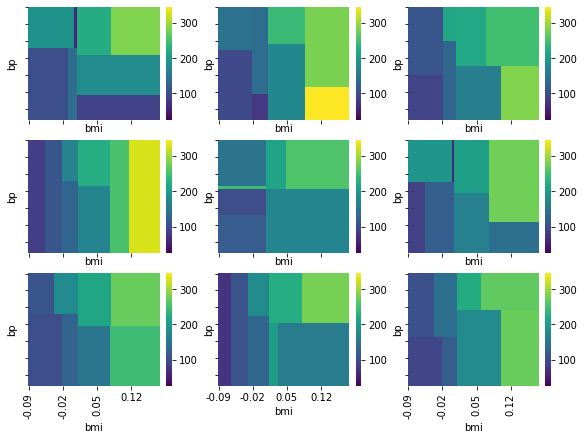

In [ ]:
axes = inspector.plot_components()

In [ ]:
# hide
test_fig_exists(axes[0, 0])

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


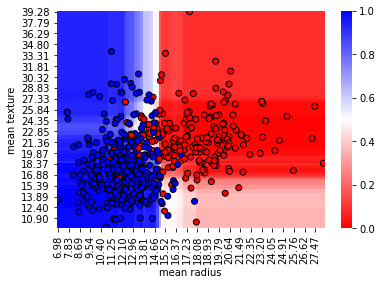

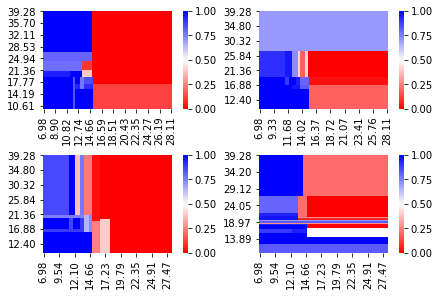

In [ ]:
rfc = RandomForestClassifier(min_samples_leaf=10).fit(X_cancer.iloc[:, :2], y_cancer)
inspector = get_inspector(rfc, X_cancer.iloc[:, :2], y_cancer)

ax = inspector.plot()
_, axes = plt.subplots(2, 2, constrained_layout=True)
axes = inspector.plot_components(axes=axes)

In [ ]:
# hide
test_fig_exists(ax)
test_fig_exists(axes[0, 0])

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


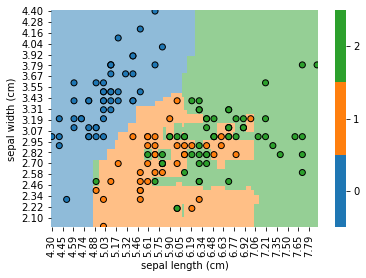

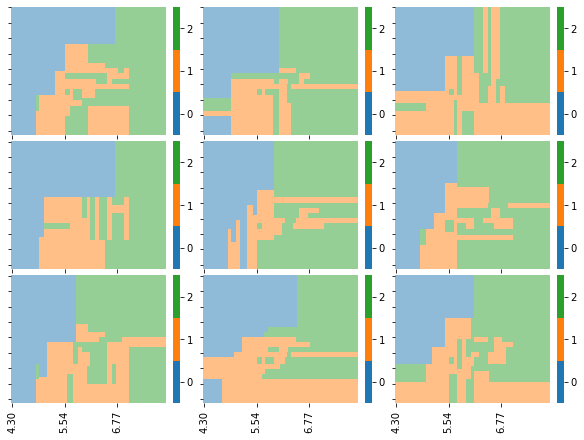

In [ ]:
rfc = RandomForestClassifier().fit(X_iris.iloc[:, :2], y_iris)
inspector = get_inspector(rfc, X_iris.iloc[:, :2], y_iris)

ax = inspector.plot()
axes = inspector.plot_components()

In [ ]:
# hide
test_fig_exists(ax)
test_fig_exists(axes[0, 0])

There is also a `.plot_components3d()` method to plot estimators within an ensemble models that has two features.

In [ ]:
from model_inspector import inspect

show_doc(  # noqa: F405
    inspect._2dMultiPlotterMixin.plot_components3d,
    title_level=4,
    name="plot_components3d",
)

<h4 id="plot_components3d" class="doc_header"><code>plot_components3d</code><a href="https://github.com/gsganden/model_inspector/tree/main/model_inspector/inspect.py#L1365" class="source_link" style="float:right">[source]</a></h4>

> <code>plot_components3d</code>(**`axes`**=*`None`*, **\*\*`kwargs`**)

Plot components estimators in 3D

Parameters:
- `axes`: NumPy array of Matplotlib `Axes` objects
- `kwargs`: kwargs to pass to `self.plot3d`

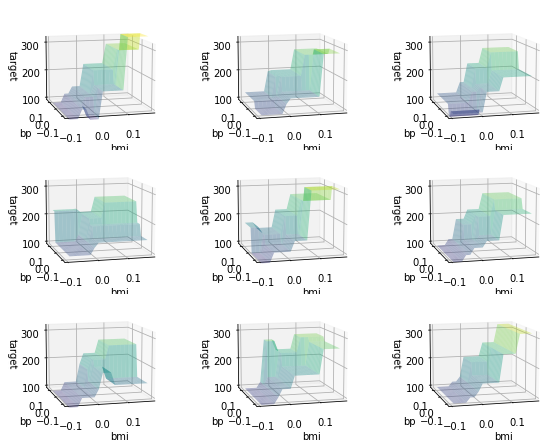

In [ ]:
axes = get_inspector(
    RandomForestRegressor(max_depth=3).fit(
        X_diabetes.loc[:, ["bmi", "bp"]], y_diabetes
    ),
    X_diabetes.loc[:, ["bmi", "bp"]],
    y_diabetes,
).plot_components3d()
for ax in axes.ravel():
    ax.view_init(elev=10.0, azim=255)

In [ ]:
# hide
test_fig_exists(axes[0, 0])